# Import library

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import networkx.algorithms.community as nx_comm
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import scipy.sparse as sp
import leidenalg
import infomap
import igraph as ig
from collections import Counter, defaultdict

# Read file

In [2]:
users = pd.read_csv("users.csv")
edges = pd.read_csv("collaboration_edges.csv")

# EDA

In [28]:
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5682 entries, 0 to 5681
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_id          5682 non-null   object
 1   login            5682 non-null   object
 2   name             4717 non-null   object
 3   bio              2433 non-null   object
 4   company          2469 non-null   object
 5   location         3148 non-null   object
 6   created_at       5682 non-null   object
 7   updated_at       5682 non-null   object
 8   public_repos     5682 non-null   int64 
 9   followers_count  5682 non-null   int64 
 10  following_count  5682 non-null   int64 
 11  organizations    1459 non-null   object
dtypes: int64(3), object(9)
memory usage: 532.8+ KB


In [29]:
edges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048503 entries, 0 to 1048502
Data columns (total 7 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   user_A              1048503 non-null  object
 1   user_B              1048503 non-null  object
 2   common_repos        1048503 non-null  object
 3   common_repos_count  1048503 non-null  int64 
 4   commit_count_A      1048503 non-null  int64 
 5   commit_count_B      1048503 non-null  int64 
 6   weight              1048503 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 56.0+ MB


In [30]:
users.describe()

,public_repos,followers_count,following_count
count,5682.000000,5682.000000,5682.000000
mean,52.506160,162.814502,30.555966
std,183.082042,1010.738013,122.131719
min,0.000000,0.000000,0.000000
25%,11.000000,4.000000,0.000000
50%,26.000000,18.000000,4.000000
75%,54.000000,67.000000,21.000000
max,8973.000000,32765.000000,4625.000000


In [31]:
edges.describe()

,common_repos_count,commit_count_A,commit_count_B,weight
count,1.048503e+06,1.048503e+06,1.048503e+06,1.048503e+06
mean,1.008232e+00,3.042305e+01,1.046376e+01,1.008232e+00
std,9.847639e-02,2.048280e+02,5.537450e+01,9.847639e-02
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
50%,1.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00
75%,1.000000e+00,8.000000e+00,5.000000e+00,1.000000e+00
max,8.000000e+00,1.237600e+04,7.708000e+03,8.000000e+00


In [ ]:
# kiểm tra giá trị thiếu
print(users.isnull().sum())
print(edges.isnull().sum())

user_id               0
login                 0
name                965
bio                3249
company            3213
location           2534
created_at            0
updated_at            0
public_repos          0
followers_count       0
following_count       0
organizations      4223
dtype: int64
user_A                0
user_B                0
common_repos          0
common_repos_count    0
commit_count_A        0
commit_count_B        0
weight                0
dtype: int64


In [ ]:
# kiểm tra giá trị trùng
print(users.duplicated().sum())
print(edges.duplicated().sum())

0
0


In [ ]:
# Chuyển kiểu dữ liệu của các cột thời gian sang datetime trong users và edges
users['created_at'] = pd.to_datetime(users['created_at'])
users['updated_at'] = pd.to_datetime(users['updated_at'])

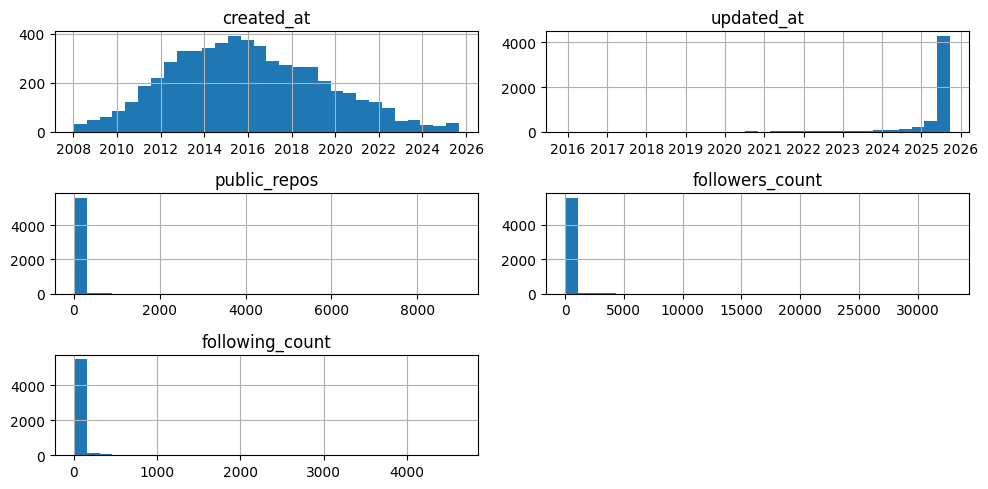

In [35]:
# Sự phân bố của các cột số trong users
users.hist(bins=30, figsize=(10, 5))
plt.tight_layout()

C:\Users\84941\AppData\Local\Temp\ipykernel_19412\3856328177.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_developers, x='login', y='followers_count', palette='viridis')
c:\Users\84941\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\84941\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_

Text(0.5, 1.0, 'Top 20 Developers by Followers')

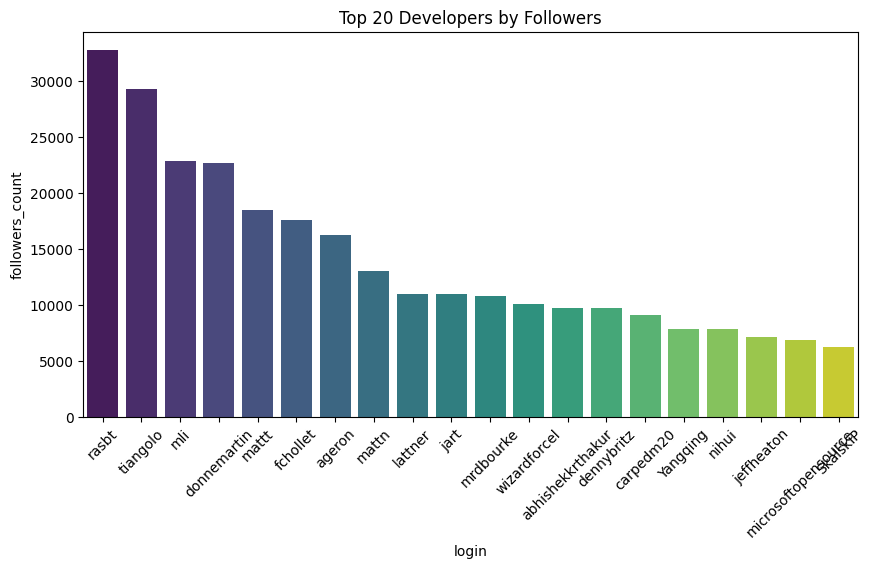

In [38]:
# Top developers theo followers
top_developers = users.nlargest(20, 'followers_count')[['login', 'followers_count', 'public_repos']]
plt.figure(figsize=(10, 5))
sns.barplot(data=top_developers, x='login', y='followers_count', palette='viridis')
plt.xticks(rotation=45)
plt.title('Top 20 Developers by Followers')

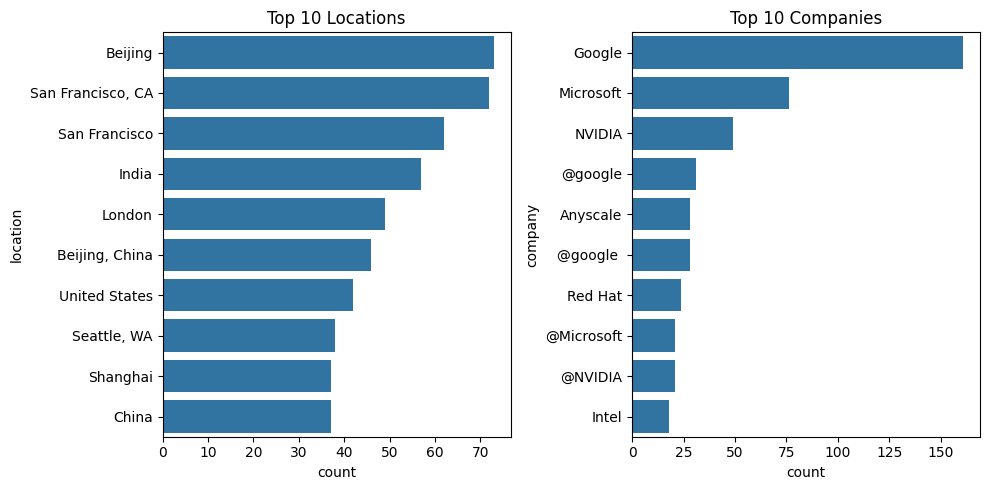

In [39]:
# Phân bố của các cột chữ (location, company) top phổ biến trong users
top_locations = users['location'].value_counts().nlargest(10).index
top_companies = users['company'].value_counts().nlargest(10).index
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(y='location', data=users[users['location'].isin(top_locations)], order=top_locations)
plt.title('Top 10 Locations')
plt.subplot(1, 2, 2)
sns.countplot(y='company', data=users[users['company'].isin(top_companies)], order=top_companies)
plt.title('Top 10 Companies')
plt.tight_layout()


TIME SERIES ANALYSIS


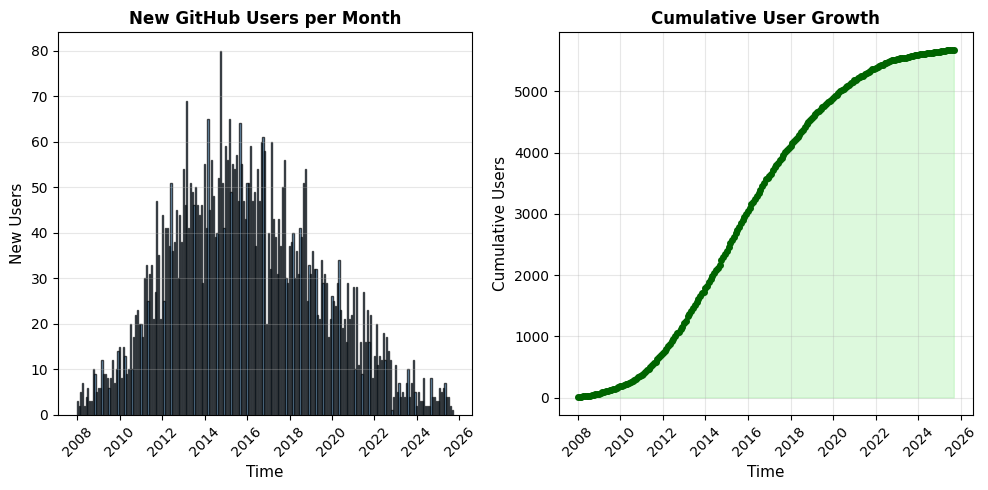


USER GROWTH STATISTICS
First user: 2008-01-13 05:57:18
Latest user: 2025-09-03 11:08:30
Peak month: 2014-10-01 00:00:00 (80 users)


In [40]:
print("\n" + "="*70)
print("TIME SERIES ANALYSIS")
print("="*70)

# Plot: User Growth Timeline
def analyze_user_growth_timeline(users_df, figsize=(10, 5)):
    """
    Phân tích sự tăng trưởng của users theo thời gian
    """
    if not pd.api.types.is_datetime64_any_dtype(users_df['created_at']):
        users_df['created_at'] = pd.to_datetime(users_df['created_at'])
    
    users_df['year_month'] = users_df['created_at'].dt.to_period('M')
    growth = users_df.groupby('year_month').size().reset_index(name='count')
    growth['cumulative'] = growth['count'].cumsum()
    growth['year_month'] = growth['year_month'].dt.to_timestamp()
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: Monthly new users
    axes[0].bar(growth['year_month'], growth['count'], 
               color='steelblue', edgecolor='black', alpha=0.7, width=20)
    axes[0].set_xlabel('Time', fontsize=11)
    axes[0].set_ylabel('New Users', fontsize=11)
    axes[0].set_title('New GitHub Users per Month', fontsize=12, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Plot 2: Cumulative growth
    axes[1].plot(growth['year_month'], growth['cumulative'], 
                marker='o', linewidth=2, markersize=4, color='darkgreen')
    axes[1].fill_between(growth['year_month'], growth['cumulative'], alpha=0.3, color='lightgreen')
    axes[1].set_xlabel('Time', fontsize=11)
    axes[1].set_ylabel('Cumulative Users', fontsize=11)
    axes[1].set_title('Cumulative User Growth', fontsize=12, fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('user_growth_timeline.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n{'='*60}")
    print("USER GROWTH STATISTICS")
    print(f"{'='*60}")
    print(f"First user: {users_df['created_at'].min()}")
    print(f"Latest user: {users_df['created_at'].max()}")
    print(f"Peak month: {growth.loc[growth['count'].idxmax(), 'year_month']} ({growth['count'].max()} users)")

analyze_user_growth_timeline(users)



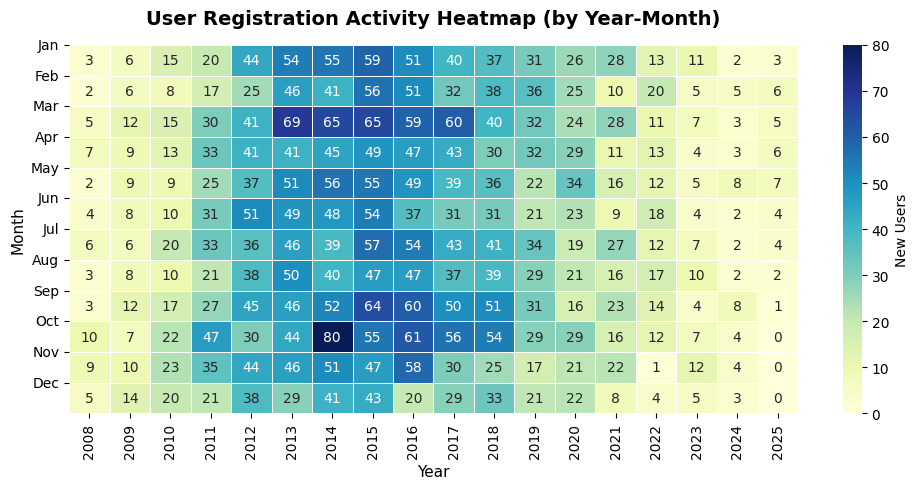

In [ ]:
# Biểu đồ : Activity Heatmap
def create_activity_heatmap(users_df, figsize=(10, 5)):
    """
    Heatmap hoạt động theo năm và tháng
    """
    users_temp = users_df.copy()
    if not pd.api.types.is_datetime64_any_dtype(users_temp['created_at']):
        users_temp['created_at'] = pd.to_datetime(users_temp['created_at'])
    
    users_temp['year'] = users_temp['created_at'].dt.year
    users_temp['month'] = users_temp['created_at'].dt.month
    
    heatmap_data = users_temp.pivot_table(
        values='user_id', 
        index='month', 
        columns='year', 
        aggfunc='count', 
        fill_value=0
    )
    
    plt.figure(figsize=figsize)
    sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu', 
                linewidths=0.5, cbar_kws={'label': 'New Users'})
    
    plt.title('User Registration Activity Heatmap (by Year-Month)', 
              fontsize=14, fontweight='bold', pad=15)
    plt.xlabel('Year', fontsize=11)
    plt.ylabel('Month', fontsize=11)
    plt.yticks(ticks=range(12), labels=[
        'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
    ], rotation=0)
    
    plt.tight_layout()
    plt.savefig('activity_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

create_activity_heatmap(users)

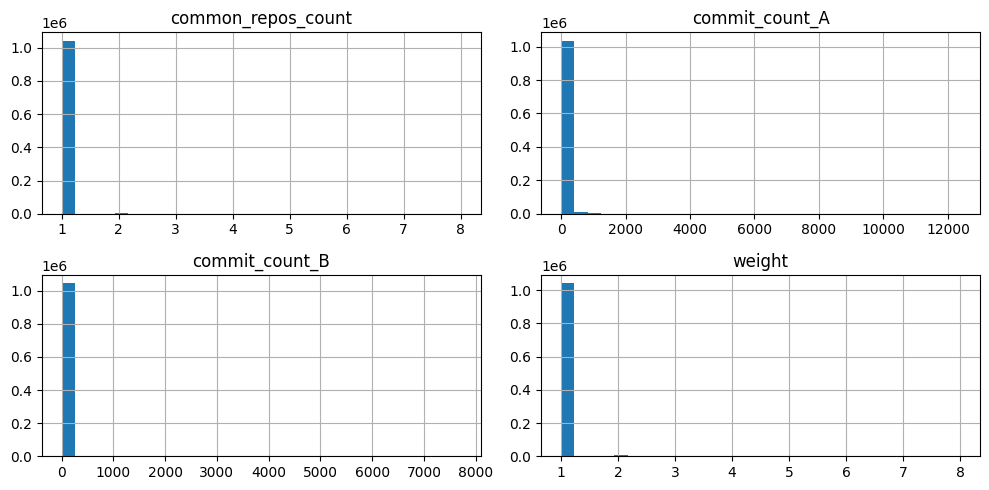

In [43]:
# Phân bố của các cột số trong edges
edges.hist(bins=30, figsize=(10, 5))
plt.tight_layout()

In [44]:
# Lấy thông tin cần thiết từ users để phân tích mạng xã hội
neccessary_user_graph = users[['user_id','login']]

In [45]:
# Lấy thông tin cần thiết từ edges để phân tích mạng xã hội
neccessary_edge_graph = edges[['user_A', 'user_B', 'weight']]

In [46]:
# Hàm chọn ra 2500 node quan trọng nhất
def select_best_2500_nodes(edges_df, users_df):
    """
    Chọn ra 2500 node (developer) quan trọng nhất dựa trên các chỉ số:
      - Degree Centrality (weighted)
      - PageRank (weighted)
      - Betweenness Centrality (weighted, sample)
    Từ đó tạo ra subgraph 2500 node này + edges + thông tin user tương ứng.
    """

    # Tạo full graph từ bảng edges có trọng số 
    G_full = nx.Graph()
    edges = [(row['user_A'], row['user_B'], row['weight']) for _, row in edges_df.iterrows()]
    G_full.add_weighted_edges_from(edges)

    print(f"Full network: {G_full.number_of_nodes()} nodes, {G_full.number_of_edges()} edges")

    # Tính các chỉ số trung tâm (centrality) có trọng số 
    print("\nCalculating weighted node importance scores...")

    degree_cent = dict(G_full.degree(weight='weight'))
    pagerank = nx.pagerank(G_full, weight='weight')

    # Giảm mẫu của betweenness để tránh chạy quá lâu
    if G_full.number_of_nodes() < 5000:
        betweenness = nx.betweenness_centrality(G_full, weight='weight', k=200)  # giảm từ 500 → 200
    else:
        betweenness = {node: 0 for node in G_full.nodes()}

    # Tính điểm tổng hợp (importance score)
    importance_scores = {}
    max_deg = max(degree_cent.values()) if degree_cent else 1
    max_pr = max(pagerank.values()) if pagerank else 1
    max_bt = max(betweenness.values()) if betweenness else 1

    for node in G_full.nodes():
        importance_scores[node] = (
            0.4 * (degree_cent[node] / max_deg) +  # 40% độ kết nối
            0.4 * (pagerank[node] / max_pr) +      # 40% PageRank
            0.2 * (betweenness[node] / max_bt if max_bt > 0 else 0)  # 20% trung gian
        )

    # Chọn top 2500 node 
    TOP_N = 2500
    top_nodes = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)[:TOP_N]
    selected_node_ids = [node for node, _ in top_nodes]

    print(f"\nSelected top {TOP_N} nodes based on weighted importance score")
    print(f"Top 5 nodes: {selected_node_ids[:5]}")

    # Tạo subgraph 2500 node 
    G_sub = G_full.subgraph(selected_node_ids).copy()

    # Lọc lại edges + users tương ứng 
    edges_sub = edges_df[
        (edges_df['user_A'].isin(selected_node_ids)) &
        (edges_df['user_B'].isin(selected_node_ids))
    ].copy()

    users_sub = users_df[users_df['user_id'].isin(selected_node_ids)].copy()

    # Thêm các chỉ số vào bảng user 
    users_sub['importance_score'] = users_sub['user_id'].map(lambda x: importance_scores.get(x, 0))
    users_sub['degree'] = users_sub['user_id'].map(lambda x: degree_cent.get(x, 0))
    users_sub['pagerank'] = users_sub['user_id'].map(lambda x: pagerank.get(x, 0))
    users_sub['betweenness'] = users_sub['user_id'].map(lambda x: betweenness.get(x, 0))
    users_sub = users_sub.sort_values('importance_score', ascending=False)

    # In thống kê
    print(f"\n{TOP_N}-Node Network Statistics:")
    print(f"   Nodes: {G_sub.number_of_nodes()}")
    print(f"   Edges: {G_sub.number_of_edges()}")
    print(f"   Density: {nx.density(G_sub):.3f}")
    print(f"   Average degree: {sum(dict(G_sub.degree(weight='weight')).values()) / G_sub.number_of_nodes():.2f}")

    return G_sub, edges_sub, users_sub

G_2500, edges_2500, users_2500 = select_best_2500_nodes(
    edges_df=neccessary_edge_graph,
    users_df=neccessary_user_graph
)


Full network: 8654 nodes, 1048503 edges

Calculating weighted node importance scores...

Selected top 2500 nodes based on weighted importance score
Top 5 nodes: ['MDM6Qm90NDk2OTkzMzM=', 'MDQ6VXNlcjIyNjMzMzg1', 'MDQ6VXNlcjM3MDk3MTU=', 'MDQ6VXNlcjExMjgxODE0', 'MDQ6VXNlcjM1NDcwOTIx']

2500-Node Network Statistics:
   Nodes: 2500
   Edges: 442836
   Density: 0.142
   Average degree: 361.15


# Xây dựng và phân tích mạng hợp tác

In [47]:
# Tạo graph với là toàn bộ node
def create_collaboration_network(edges_df, users_df):
    """
    Tạo đồ thị mạng lưới hợp tác giữa các developer từ dữ liệu edges (có trọng số).
    Mỗi cạnh (edge) đại diện cho một mối quan hệ hợp tác giữa hai user.
    """

    # Tạo graph
    G = nx.Graph()

    # Nếu có cột 'weight' thì dùng weighted edges, ngược lại dùng weight=1
    if 'weight' in edges_df.columns:
        edges = [(row['user_A'], row['user_B'], row['weight']) for _, row in edges_df.iterrows()]
        G.add_weighted_edges_from(edges)
    else:
        edges = [(row['user_A'], row['user_B'], 1) for _, row in edges_df.iterrows()]
        G.add_weighted_edges_from(edges)

    print(f"\n=== Collaboration Network Created ===")
    print(f"Total nodes: {G.number_of_nodes()}")
    print(f"Total edges: {G.number_of_edges()}")
    print(f"Network density: {nx.density(G):.4f}")

    # Thêm thuộc tính node từ users_df 
    user_dict = users_df.set_index('user_id').to_dict('index')
    missing_users = 0

    for node in G.nodes():
        if node in user_dict:
            for key, value in user_dict[node].items():
                G.nodes[node][key] = value
        else:
            # Nếu user không có trong users.csv
            G.nodes[node]['login'] = f"unknown_{node}"
            G.nodes[node]['name'] = f"User_{node}"
            missing_users += 1

    # if missing_users > 0:
        # print(f"Warning: {missing_users} users in edges not found in users.csv")

    # Kiểm tra cấu trúc mạng 
    if nx.is_connected(G):
        print(f"Graph is connected")
        print(f"Diameter: {nx.diameter(G)}")
        print(f"Average shortest path length: {nx.average_shortest_path_length(G):.2f}")
    else:
        num_components = nx.number_connected_components(G)
        largest_cc = max(nx.connected_components(G), key=len)
        print(f"Graph has {num_components} connected components")
        print(f"Largest component size: {len(largest_cc)} nodes")

    return G


G_all  = create_collaboration_network(
    edges_df=neccessary_edge_graph,
    users_df=neccessary_user_graph
)



=== Collaboration Network Created ===
Total nodes: 8654
Total edges: 1048503
Network density: 0.0280
Graph has 11 connected components
Largest component size: 8507 nodes



DEGREE DISTRIBUTION ANALYSIS


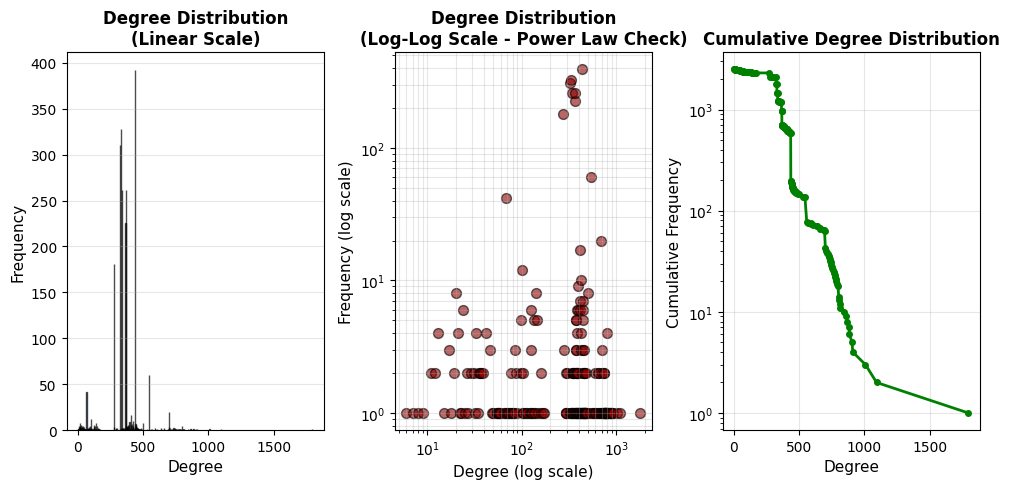


DEGREE DISTRIBUTION STATISTICS
Average degree: 354.27
Median degree: 337.00
Max degree: 1795
Min degree: 6
Std deviation: 122.80


In [48]:
print("\n" + "="*70)
print("DEGREE DISTRIBUTION ANALYSIS")
print("="*70)

# Biểu đồ 7: Degree Distribution
def analyze_degree_distribution(G, figsize=(10, 5)):
    """
    Phân tích phân bố degree - kiểm tra power law
    """
    degrees = [d for n, d in G.degree()]
    degree_counts = Counter(degrees)
    
    deg, cnt = zip(*sorted(degree_counts.items()))
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # 1. Linear scale
    axes[0].bar(deg, cnt, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Degree', fontsize=11)
    axes[0].set_ylabel('Frequency', fontsize=11)
    axes[0].set_title('Degree Distribution\n(Linear Scale)', fontsize=12, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    
    # 2. Log-log scale (Power law check)
    axes[1].scatter(deg, cnt, color='darkred', alpha=0.6, s=50, edgecolors='black')
    axes[1].set_xscale('log')
    axes[1].set_yscale('log')
    axes[1].set_xlabel('Degree (log scale)', fontsize=11)
    axes[1].set_ylabel('Frequency (log scale)', fontsize=11)
    axes[1].set_title('Degree Distribution\n(Log-Log Scale - Power Law Check)', 
                      fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3, which='both')
    
    # 3. Cumulative distribution
    cumulative = np.cumsum(cnt[::-1])[::-1]
    axes[2].plot(deg, cumulative, marker='o', color='green', linewidth=2, markersize=4)
    axes[2].set_xlabel('Degree', fontsize=11)
    axes[2].set_ylabel('Cumulative Frequency', fontsize=11)
    axes[2].set_title('Cumulative Degree Distribution', fontsize=12, fontweight='bold')
    axes[2].grid(alpha=0.3)
    axes[2].set_yscale('log')
    
    plt.tight_layout()
    plt.savefig('degree_distribution_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Statistics
    print(f"\n{'='*60}")
    print("DEGREE DISTRIBUTION STATISTICS")
    print(f"{'='*60}")
    print(f"Average degree: {np.mean(degrees):.2f}")
    print(f"Median degree: {np.median(degrees):.2f}")
    print(f"Max degree: {max(degrees)}")
    print(f"Min degree: {min(degrees)}")
    print(f"Std deviation: {np.std(degrees):.2f}")

analyze_degree_distribution(G_2500)

# Phân cụm cộng đồng (Community Detection)

In [19]:
# Phát hiện cộng đồng bằng nhiều thuật toán
def detect_communities_multiple_methods(G):
    """
    Phát hiện cộng đồng (community detection) bằng nhiều thuật toán:
      1. Louvain (greedy modularity)
      2. Label Propagation
      3. Spectral Clustering
      4. Infomap
      5. Leiden
    """

    results = {}

    print("\n" + "=" * 60)
    print("COMMUNITY DETECTION ANALYSIS")
    print("=" * 60)

    # Louvain / Greedy Modularity
    print("\nLOUVAIN / GREEDY MODULARITY METHOD")
    try:
        louvain_communities = nx_comm.greedy_modularity_communities(G, weight='weight')
        louvain_dict = {node: i for i, comm in enumerate(louvain_communities) for node in comm}
        louvain_modularity = nx_comm.modularity(G, louvain_communities, weight='weight')

        print(f"Communities found: {len(louvain_communities)}")
        print(f"Modularity: {louvain_modularity:.4f}")
        print(f"Top 5 community sizes: {sorted([len(c) for c in louvain_communities], reverse=True)[:5]}")

        results['louvain'] = {
            'communities': louvain_communities,
            'mapping': louvain_dict,
            'modularity': louvain_modularity
        }
    except Exception as e:
        print(f"Louvain failed: {e}")

    # Label Propagation
    print("\nLABEL PROPAGATION METHOD")
    try:
        label_prop_communities = list(nx_comm.label_propagation_communities(G))
        label_prop_dict = {node: i for i, comm in enumerate(label_prop_communities) for node in comm}
        label_prop_modularity = nx_comm.modularity(G, label_prop_communities, weight='weight')

        print(f"Communities found: {len(label_prop_communities)}")
        print(f"Modularity: {label_prop_modularity:.4f}")

        results['label_propagation'] = {
            'communities': label_prop_communities,
            'mapping': label_prop_dict,
            'modularity': label_prop_modularity
        }
    except Exception as e:
        print(f"Label Propagation failed: {e}")

    # Spectral Clustering
    print("\nSPECTRAL CLUSTERING METHOD")
    try:
        from sklearn.cluster import SpectralClustering

        adj_matrix = nx.to_numpy_array(G, weight='weight')
        n_clusters = min(20, max(2, G.number_of_nodes() // 100))

        spectral = SpectralClustering(
            n_clusters=n_clusters,
            affinity='precomputed',
            assign_labels='discretize',
            random_state=42
        )
        labels = spectral.fit_predict(adj_matrix)

        communities = defaultdict(set)
        for node, label in zip(G.nodes(), labels):
            communities[label].add(node)

        communities_list = list(communities.values())
        modularity = nx_comm.modularity(G, communities_list, weight='weight')

        print(f"Communities: {len(communities_list)}")
        print(f"Modularity: {modularity:.4f}")

        results['spectral'] = {
            'communities': communities_list,
            'modularity': modularity
        }
    except Exception as e:
        print(f"Spectral clustering failed: {e}")

    # Infomap
    print("\nINFOMAP METHOD")
    try:
        import infomap

        all_communities = []
        for component in nx.connected_components(G):
            if len(component) > 1:
                subgraph = G.subgraph(component)
                nodes = list(subgraph.nodes())
                node_to_int = {n: i for i, n in enumerate(nodes)}

                im = infomap.Infomap()
                for u, v, data in subgraph.edges(data=True):
                    weight = data.get('weight', 1)
                    im.add_link(node_to_int[u], node_to_int[v], weight)

                im.run()

                communities = defaultdict(set)
                for node in im.tree:
                    if node.is_leaf:
                        communities[node.module_id].add(nodes[node.node_id])

                all_communities.extend(communities.values())
            else:
                all_communities.append(component)

        modularity = nx_comm.modularity(G, all_communities, weight='weight')

        print(f"Communities: {len(all_communities)}")
        print(f"Modularity: {modularity:.4f}")

        results['infomap'] = {
            'communities': all_communities,
            'modularity': modularity
        }
    except Exception as e:
        print(f"Infomap failed: {e}")

    # Leiden
    print("\nLEIDEN METHOD")
    try:
        import igraph as ig
        import leidenalg

        nodes = list(G.nodes())
        node_to_idx = {n: i for i, n in enumerate(nodes)}

        G_ig = ig.Graph()
        G_ig.add_vertices(len(nodes))
        edges = [(node_to_idx[u], node_to_idx[v]) for u, v in G.edges()]
        G_ig.add_edges(edges)

        # Chạy Leiden
        partition = leidenalg.find_partition(G_ig, leidenalg.RBConfigurationVertexPartition)

        communities = defaultdict(set)
        for idx, comm_id in enumerate(partition.membership):
            communities[comm_id].add(nodes[idx])

        communities_list = list(communities.values())
        modularity = nx_comm.modularity(G, communities_list, weight='weight')

        print(f"Communities: {len(communities_list)}")
        print(f"Modularity: {modularity:.4f}")

        results['leiden'] = {
            'communities': communities_list,
            'modularity': modularity
        }
    except Exception as e:
        print(f"Leiden failed: {e}")

    print("\nCommunity detection completed across all methods.")
    return results


community_results = detect_communities_multiple_methods(G_all)



COMMUNITY DETECTION ANALYSIS

LOUVAIN / GREEDY MODULARITY METHOD
Communities found: 41
Modularity: 0.8260
Top 5 community sizes: [1209, 561, 528, 516, 439]

LABEL PROPAGATION METHOD
Communities found: 43
Modularity: 0.6561

SPECTRAL CLUSTERING METHOD


c:\Users\84941\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Communities: 20
Modularity: 0.6642

INFOMAP METHOD
Communities: 85
Modularity: 0.8359

LEIDEN METHOD
Communities: 41
Modularity: 0.8486

Community detection completed across all methods.


In [49]:
# Tạo bảng so sánh các thuật toán phát hiện cộng đồng

def summarize_community_results(community_results):
    """
    Tạo bảng so sánh các thuật toán phát hiện cộng đồng.
    Input: community_results (dict)
    Output: DataFrame so sánh
    """

    summary_data = []

    for method, result in community_results.items():
        try:
            # result is a dict with keys: 'communities', 'modularity', etc.
            communities = result.get('communities', [])
            modularity = result.get('modularity', None)
            n_communities = len(communities)
            avg_size = sum(len(c) for c in communities) / n_communities if n_communities > 0 else 0

            summary_data.append({
                "Thuật toán": method,
                "Số cộng đồng": n_communities,
                "Modularity": round(modularity, 4) if modularity is not None else None,
                # "Kích thước TB": round(avg_size, 2)
            })
        except Exception as e:
            summary_data.append({
                "Thuật toán": method,
                "Số cộng đồng": "Lỗi",
                "Modularity": None,
                # "Kích thước TB": None,
                # "Ghi chú": str(e)
            })

    df_summary = pd.DataFrame(summary_data)
    df_summary = df_summary.sort_values(by="Modularity", ascending=False, na_position="last").reset_index(drop=True)

    print("\nBẢNG SO SÁNH CÁC THUẬT TOÁN PHÁT HIỆN CỘNG ĐỒNG")
    print(df_summary.to_string(index=False))
    return df_summary

summary_df = summarize_community_results(community_results)



BẢNG SO SÁNH CÁC THUẬT TOÁN PHÁT HIỆN CỘNG ĐỒNG
       Thuật toán  Số cộng đồng  Modularity
           leiden            41      0.8486
          infomap            85      0.8359
          louvain            41      0.8260
         spectral            20      0.6642
label_propagation            43      0.6561


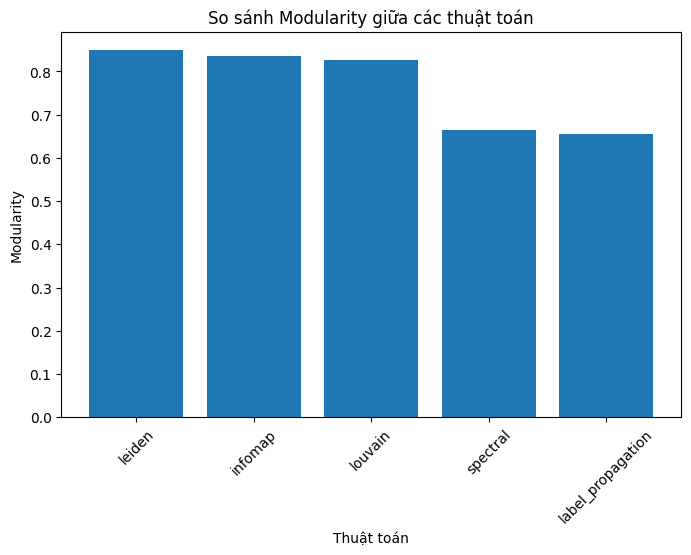

In [50]:
# Vẽ biểu đồ so sánh Modularity giữa các thuật toán

plt.figure(figsize=(8,5))
plt.bar(summary_df["Thuật toán"], summary_df["Modularity"])
plt.title("So sánh Modularity giữa các thuật toán")
plt.ylabel("Modularity")
plt.xlabel("Thuật toán")
plt.xticks(rotation=45)
plt.show()


# Phân tích & trực quan kết quả cộng đồng


COMMUNITY VISUALIZATION

VISUALIZING COMMUNITIES - LEIDEN
Calculating layout...


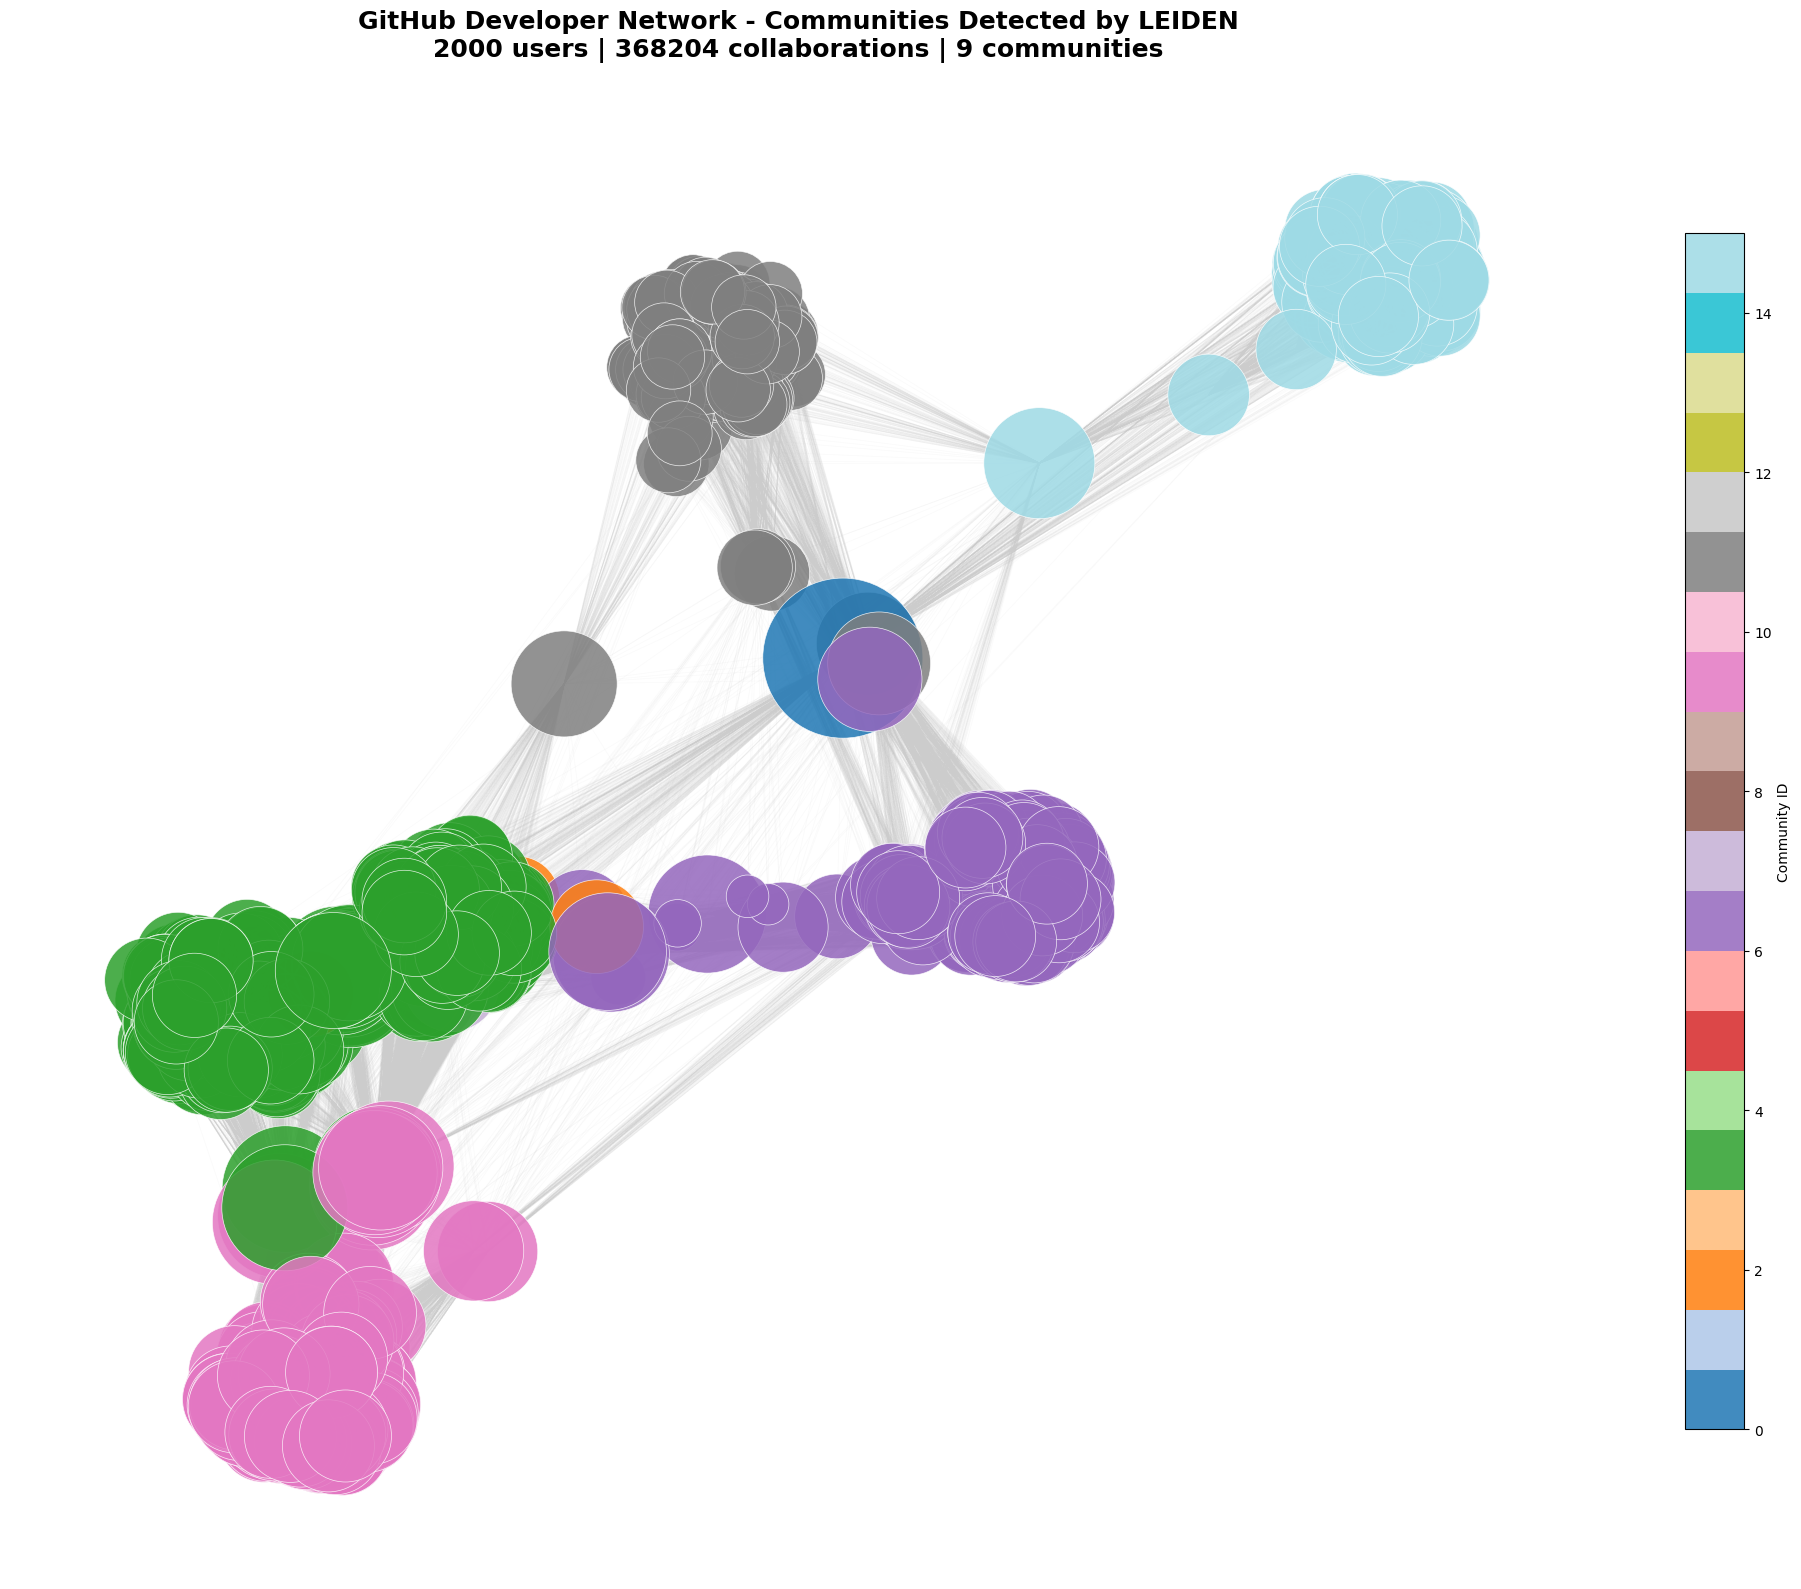

Found 9 communities
Visualization saved.



In [ ]:
print("\n" + "="*70)
print("COMMUNITY VISUALIZATION")
print("="*70)
# Biểu đồ : Network với Communities (màu theo cộng đồng)
def visualize_communities_on_network(G, communities_dict, method_name='louvain', 
                                      top_n_nodes=1500, figsize=(20, 16)):
    """
    Vẽ mạng lưới với màu sắc theo cộng đồng
    """
    print(f"\n{'='*60}")
    print(f"VISUALIZING COMMUNITIES - {method_name.upper()}")
    print(f"{'='*60}")
    
    # Lấy communities từ result
    if isinstance(communities_dict, dict):
        if 'mapping' in communities_dict:
            comm_map = communities_dict['mapping']
        elif 'communities' in communities_dict:
            comms = communities_dict['communities']
            comm_map = {node: i for i, comm in enumerate(comms) for node in comm}
        else:
            comm_map = communities_dict
    else:
        comm_map = {node: i for i, comm in enumerate(communities_dict) for node in comm}
    
    # Sample nodes nếu quá lớn
    if G.number_of_nodes() > top_n_nodes:
        degrees = dict(G.degree())
        top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:top_n_nodes]
        sampled_nodes = [n for n, _ in top_nodes]
        H = G.subgraph(sampled_nodes).copy()
    else:
        H = G
    
    # Layout
    print("Calculating layout...")
    pos = nx.spring_layout(H, k=1/np.sqrt(H.number_of_nodes()), iterations=50, seed=42)
    
    # Màu sắc theo community
    node_colors = [comm_map.get(node, -1) for node in H.nodes()]
    n_communities = len(set(node_colors))
    
    # Kích thước node theo degree
    node_sizes = [H.degree(node) * 10 + 20 for node in H.nodes()]
    
    # Vẽ
    fig, ax = plt.subplots(figsize=figsize)
    
    # Edges
    nx.draw_networkx_edges(H, pos, alpha=0.1, edge_color='#CCCCCC', width=0.5, ax=ax)
    
    # Nodes
    nodes = nx.draw_networkx_nodes(
        H, pos,
        node_color=node_colors,
        node_size=node_sizes,
        cmap='tab20',
        alpha=0.85,
        edgecolors='white',
        linewidths=0.5,
        ax=ax
    )
    
    plt.title(
        f'GitHub Developer Network - Communities Detected by {method_name.upper()}\n'
        f'{H.number_of_nodes()} users | {H.number_of_edges()} collaborations | {n_communities} communities',
        fontsize=18, fontweight='bold', pad=20
    )
    plt.axis('off')
    plt.tight_layout()
    
    # Colorbar
    plt.colorbar(nodes, label='Community ID', shrink=0.8)
    
    plt.savefig(f'network_communities_{method_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Found {n_communities} communities")
    print("Visualization saved.\n")

# Vẽ với thuật toán tốt nhất
best_method = summary_df.iloc[0]['Thuật toán']
visualize_communities_on_network(G_2500, community_results[best_method], 
                                  method_name=best_method, top_n_nodes=2000)

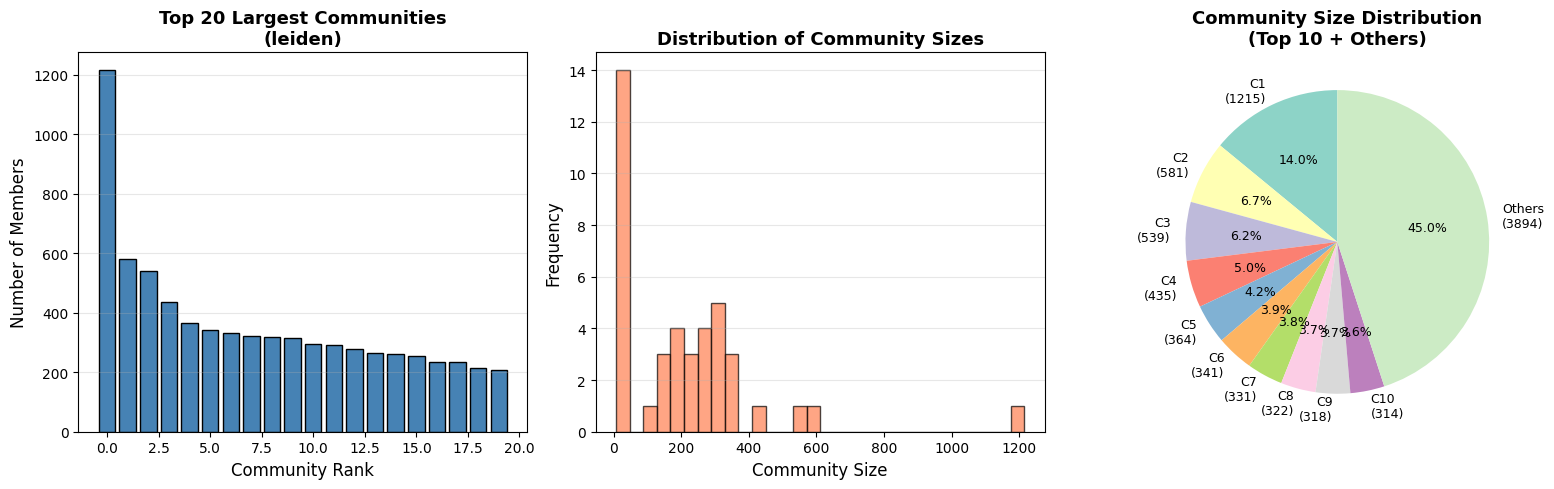


COMMUNITY SIZE STATISTICS
Total communities: 41
Largest community: 1215 members
Smallest community: 7 members
Average size: 211.07
Median size: 205.00
Std dev: 219.12


In [52]:
# Biểu đồ : Phân bố kích thước Communities
def analyze_community_sizes(community_results, figsize=(16, 5)):
    """
    Phân tích và vẽ phân bố kích thước các cộng đồng
    """
    best_method = max(community_results.items(), 
                     key=lambda x: x[1].get('modularity', 0))
    method_name, result = best_method
    communities = result['communities']
    
    # Tính kích thước
    sizes = [len(c) for c in communities]
    sizes_sorted = sorted(sizes, reverse=True)
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # 1. Bar chart - Top 20 communities
    axes[0].bar(range(min(20, len(sizes_sorted))), sizes_sorted[:20], 
                color='steelblue', edgecolor='black')
    axes[0].set_xlabel('Community Rank', fontsize=12)
    axes[0].set_ylabel('Number of Members', fontsize=12)
    axes[0].set_title(f'Top 20 Largest Communities\n({method_name})', 
                      fontsize=13, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    
    # 2. Histogram - Phân bố
    axes[1].hist(sizes, bins=30, color='coral', edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Community Size', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title('Distribution of Community Sizes', fontsize=13, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    
    # 3. Pie chart - Top 10 + Others
    top_10_sizes = sizes_sorted[:10]
    others = sum(sizes_sorted[10:])
    labels = [f'C{i+1}\n({s})' for i, s in enumerate(top_10_sizes)] + [f'Others\n({others})']
    values = top_10_sizes + [others]
    
    colors = plt.cm.Set3(range(len(values)))
    axes[2].pie(values, labels=labels, autopct='%1.1f%%', startangle=90, 
                colors=colors, textprops={'fontsize': 9})
    axes[2].set_title('Community Size Distribution\n(Top 10 + Others)', 
                      fontsize=13, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('community_size_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Statistics
    print(f"\n{'='*60}")
    print("COMMUNITY SIZE STATISTICS")
    print(f"{'='*60}")
    print(f"Total communities: {len(sizes)}")
    print(f"Largest community: {max(sizes)} members")
    print(f"Smallest community: {min(sizes)} members")
    print(f"Average size: {np.mean(sizes):.2f}")
    print(f"Median size: {np.median(sizes):.2f}")
    print(f"Std dev: {np.std(sizes):.2f}")
    
    return sizes

community_sizes = analyze_community_sizes(community_results)

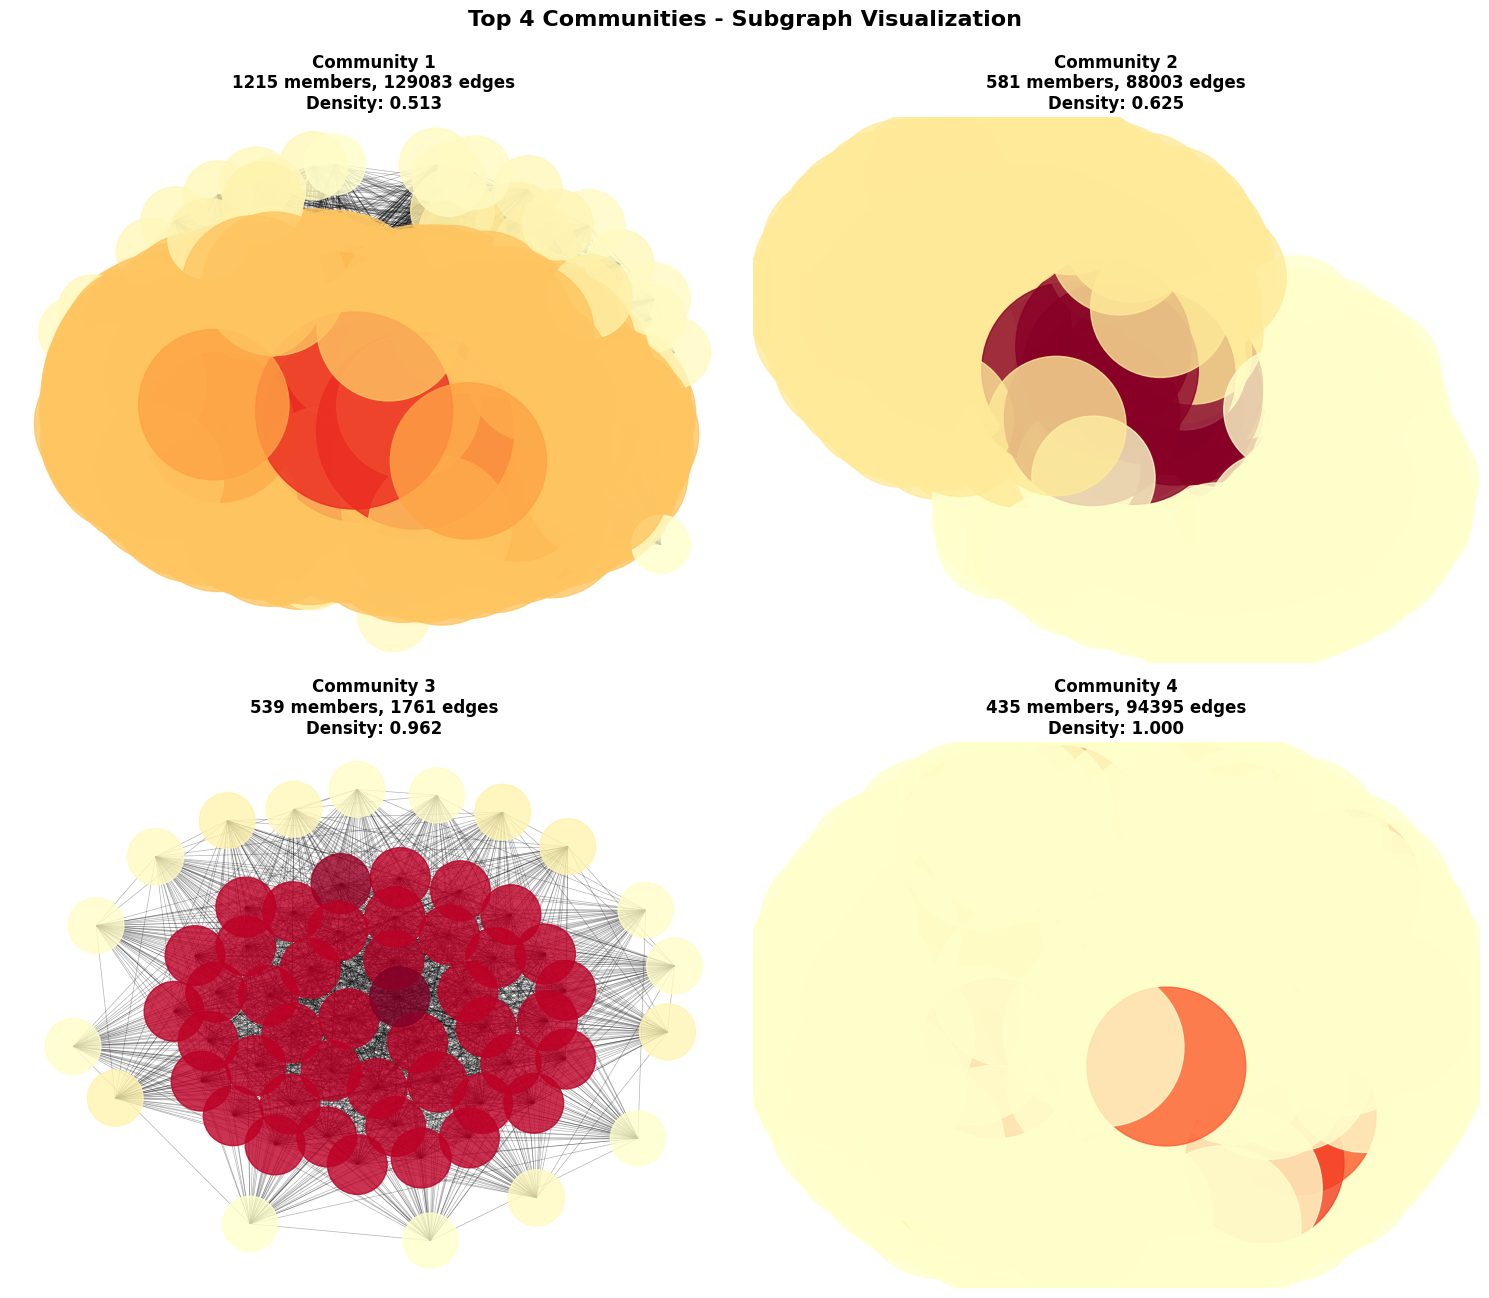

In [53]:
# Biểu đồ : Subgraph của Top Communities
def visualize_top_communities_subgraphs(G, community_results, n_communities=4):
    """
    Vẽ subgraph của các communities lớn nhất
    """
    best_method = max(community_results.items(), 
                     key=lambda x: x[1].get('modularity', 0))
    method_name, result = best_method
    communities = result['communities']
    communities_sorted = sorted(communities, key=len, reverse=True)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 13))
    axes = axes.flatten()
    
    for i, comm in enumerate(communities_sorted[:n_communities]):
        comm_nodes = list(comm)
        subgraph = G.subgraph(comm_nodes)
        
        # Layout
        if len(comm_nodes) > 100:
            pos = nx.spring_layout(subgraph, k=1, iterations=30, seed=42)
        else:
            pos = nx.kamada_kawai_layout(subgraph)
        
        # Node sizes by degree
        node_sizes = [subgraph.degree(n) * 30 + 50 for n in subgraph.nodes()]
        
        # PageRank for colors
        try:
            pr = nx.pagerank(subgraph, weight='weight')
            node_colors = [pr[n] * 1000 for n in subgraph.nodes()]
        except:
            node_colors = 'lightblue'
        
        # Draw
        ax = axes[i]
        nx.draw_networkx_nodes(subgraph, pos, 
                              node_size=node_sizes,
                              node_color=node_colors,
                              cmap='YlOrRd',
                              alpha=0.8,
                              ax=ax)
        nx.draw_networkx_edges(subgraph, pos, alpha=0.3, width=0.5, ax=ax)
        
        # Labels for top nodes
        if len(comm_nodes) <= 50:
            labels = {n: str(n)[:8] for n in list(subgraph.nodes())[:10]}
            nx.draw_networkx_labels(subgraph, pos, labels, font_size=7, ax=ax)
        
        ax.set_title(
            f'Community {i+1}\n{len(comm_nodes)} members, {subgraph.number_of_edges()} edges\n'
            f'Density: {nx.density(subgraph):.3f}',
            fontsize=12, fontweight='bold'
        )
        ax.axis('off')
    
    plt.suptitle(f'Top {n_communities} Communities - Subgraph Visualization', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('top_communities_subgraphs.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_top_communities_subgraphs(G_2500, community_results, n_communities=4)

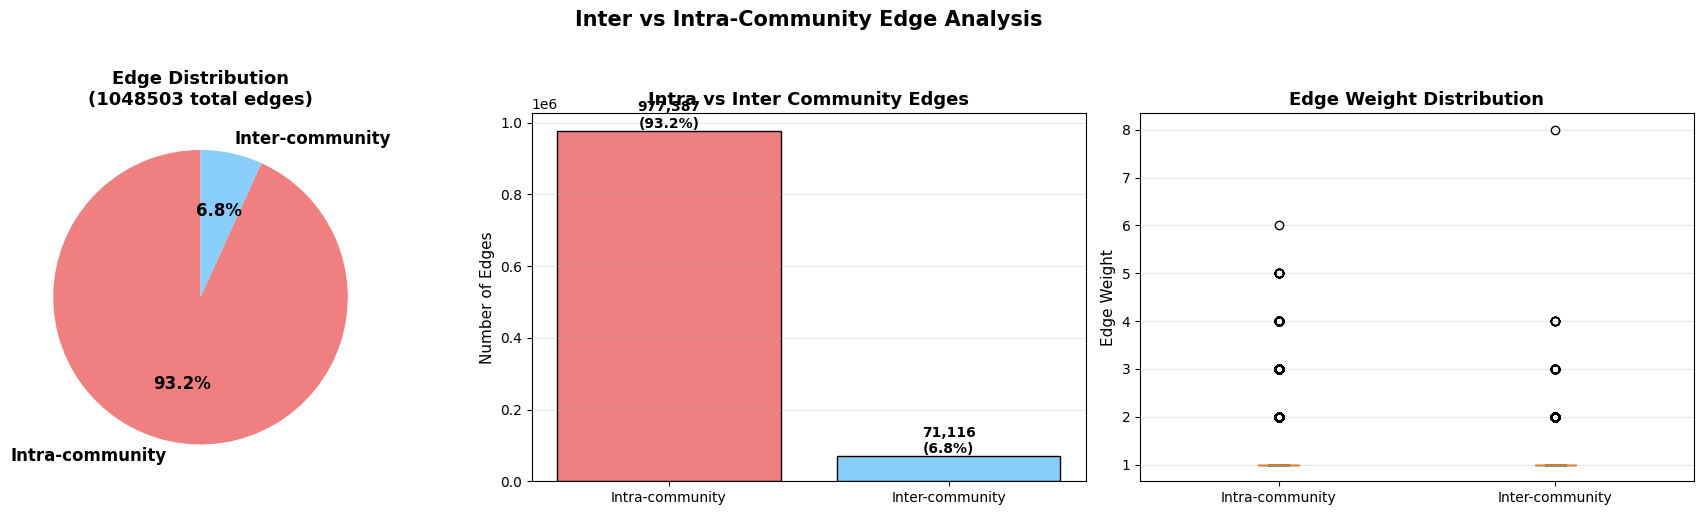


INTER VS INTRA-COMMUNITY EDGES ANALYSIS
Total edges: 1,048,503
Intra-community edges: 977,387 (93.22%)
Inter-community edges: 71,116 (6.78%)

Avg weight (intra): 1.01
Avg weight (inter): 1.01


In [54]:
# Biểu đồ : Inter vs Intra Community Edges
def analyze_inter_intra_community_edges(G, community_results):
    """
    Phân tích edges giữa communities vs trong communities
    """
    best_method = max(community_results.items(), key=lambda x: x[1].get('modularity', 0))
    method_name, result = best_method
    communities = result['communities']
    
    # Create mapping
    comm_map = {node: i for i, comm in enumerate(communities) for node in comm}
    
    intra_edges = 0
    inter_edges = 0
    inter_weights = []
    intra_weights = []
    
    for u, v, data in G.edges(data=True):
        weight = data.get('weight', 1)
        
        if comm_map.get(u) == comm_map.get(v):
            intra_edges += 1
            intra_weights.append(weight)
        else:
            inter_edges += 1
            inter_weights.append(weight)
    
    total_edges = intra_edges + inter_edges
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Pie chart
    axes[0].pie([intra_edges, inter_edges], 
               labels=['Intra-community', 'Inter-community'],
               autopct='%1.1f%%',
               colors=['lightcoral', 'lightskyblue'],
               startangle=90,
               textprops={'fontsize': 12, 'fontweight': 'bold'})
    axes[0].set_title(f'Edge Distribution\n({total_edges} total edges)', 
                     fontsize=13, fontweight='bold')
    
    # 2. Bar chart
    axes[1].bar(['Intra-community', 'Inter-community'], 
               [intra_edges, inter_edges],
               color=['lightcoral', 'lightskyblue'],
               edgecolor='black')
    axes[1].set_ylabel('Number of Edges', fontsize=11)
    axes[1].set_title('Intra vs Inter Community Edges', fontsize=13, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    
    for i, v in enumerate([intra_edges, inter_edges]):
        axes[1].text(i, v, f'{v:,}\n({v/total_edges*100:.1f}%)', 
                    ha='center', va='bottom', fontweight='bold')
    
    # 3. Weight comparison
    axes[2].boxplot([intra_weights, inter_weights], 
                   labels=['Intra-community', 'Inter-community'],
                   patch_artist=True)
    axes[2].set_ylabel('Edge Weight', fontsize=11)
    axes[2].set_title('Edge Weight Distribution', fontsize=13, fontweight='bold')
    axes[2].grid(axis='y', alpha=0.3)
    
    plt.suptitle('Inter vs Intra-Community Edge Analysis', 
                 fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('inter_intra_community_edges.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n{'='*60}")
    print("INTER VS INTRA-COMMUNITY EDGES ANALYSIS")
    print(f"{'='*60}")
    print(f"Total edges: {total_edges:,}")
    print(f"Intra-community edges: {intra_edges:,} ({intra_edges/total_edges*100:.2f}%)")
    print(f"Inter-community edges: {inter_edges:,} ({inter_edges/total_edges*100:.2f}%)")
    print(f"\nAvg weight (intra): {np.mean(intra_weights):.2f}")
    print(f"Avg weight (inter): {np.mean(inter_weights):.2f}")

analyze_inter_intra_community_edges(G_all, community_results)

In [56]:
# Tính các chỉ số mạng xã hội cho từng node trong graph 

def calculate_network_metrics(G):
    """Calculate various network metrics for each node in the graph G."""
    print("\n" + "="*60)
    print("CALCULATING NETWORK METRICS")
    print("="*60)

    n_nodes = G.number_of_nodes()
    print(f"Total nodes: {n_nodes}")
    print(f"Total edges: {G.number_of_edges()}")

    metrics = {}

    # Degree centrality
    print("\nCalculating degree centrality...")
    degree_cent = nx.degree_centrality(G)

    # Betweenness centrality 
    print("Calculating betweenness centrality...")
    if n_nodes > 2000:
        sample_k = min(200, n_nodes // 10)
        print(f"Large graph detected — using approximation with k={sample_k}")
        betweenness_cent = nx.betweenness_centrality(G, k=sample_k)
    else:
        betweenness_cent = nx.betweenness_centrality(G)

    # Closeness centrality
    print("Calculating closeness centrality...")
    closeness_cent = nx.closeness_centrality(G)

    # Eigenvector centrality
    print("Calculating eigenvector centrality...")
    try:
        eigenvector_cent = nx.eigenvector_centrality(G, max_iter=500)
    except Exception as e:
        print(f"Eigenvector centrality failed: {e}")
        eigenvector_cent = {node: 0 for node in G.nodes()}

    # PageRank
    print("Calculating PageRank...")
    pagerank = nx.pagerank(G, alpha=0.85, max_iter=100)

    # Clustering coefficient
    print("Calculating clustering coefficient...")
    clustering = nx.clustering(G)

    # Tổng hợp các chỉ số vào DataFrame
    print("\nBuilding metrics DataFrame...")
    for node in G.nodes():
        metrics[node] = {
            'user_id': node,
            'name': G.nodes[node].get('name', f'User_{node}'),
            'degree': G.degree(node),
            'degree_centrality': degree_cent.get(node, 0),
            'betweenness_centrality': betweenness_cent.get(node, 0),
            'closeness_centrality': closeness_cent.get(node, 0),
            'eigenvector_centrality': eigenvector_cent.get(node, 0),
            'pagerank': pagerank.get(node, 0),
            'clustering_coefficient': clustering.get(node, 0)
        }

    metrics_df = pd.DataFrame.from_dict(metrics, orient='index')
    metrics_df = metrics_df.sort_values('degree', ascending=False).reset_index(drop=True)

    print("\nMetrics calculation complete.")
    print(f"Top nodes by degree:")
    print(metrics_df[['user_id', 'name', 'degree']].head(5))

    return metrics_df


metrics_df = calculate_network_metrics(G_2500)

print("\nTOP MOST CONNECTED USERS")
print(metrics_df[['name', 'degree', 'pagerank', 'betweenness_centrality']].head(10))



CALCULATING NETWORK METRICS
Total nodes: 2500
Total edges: 442836

Calculating degree centrality...
Calculating betweenness centrality...
Large graph detected — using approximation with k=200
Calculating closeness centrality...
Calculating eigenvector centrality...
Calculating PageRank...
Calculating clustering coefficient...

Building metrics DataFrame...

Metrics calculation complete.
Top nodes by degree:
                user_id                       name  degree
0  MDM6Qm90NDk2OTkzMzM=  User_MDM6Qm90NDk2OTkzMzM=    1795
1  MDQ6VXNlcjM1NDcwOTIx  User_MDQ6VXNlcjM1NDcwOTIx    1094
2  MDQ6VXNlcjIyNjMzMzg1  User_MDQ6VXNlcjIyNjMzMzg1    1009
3  MDQ6VXNlcjExMzA2ODA5  User_MDQ6VXNlcjExMzA2ODA5     912
4  MDQ6VXNlcjU4ODAzODY=  User_MDQ6VXNlcjU4ODAzODY=     906

TOP MOST CONNECTED USERS
                        name  degree  pagerank  betweenness_centrality
0  User_MDM6Qm90NDk2OTkzMzM=    1795  0.002585                0.287335
1  User_MDQ6VXNlcjM1NDcwOTIx    1094  0.001129                0.04


CENTRALITY MEASURES ANALYSIS


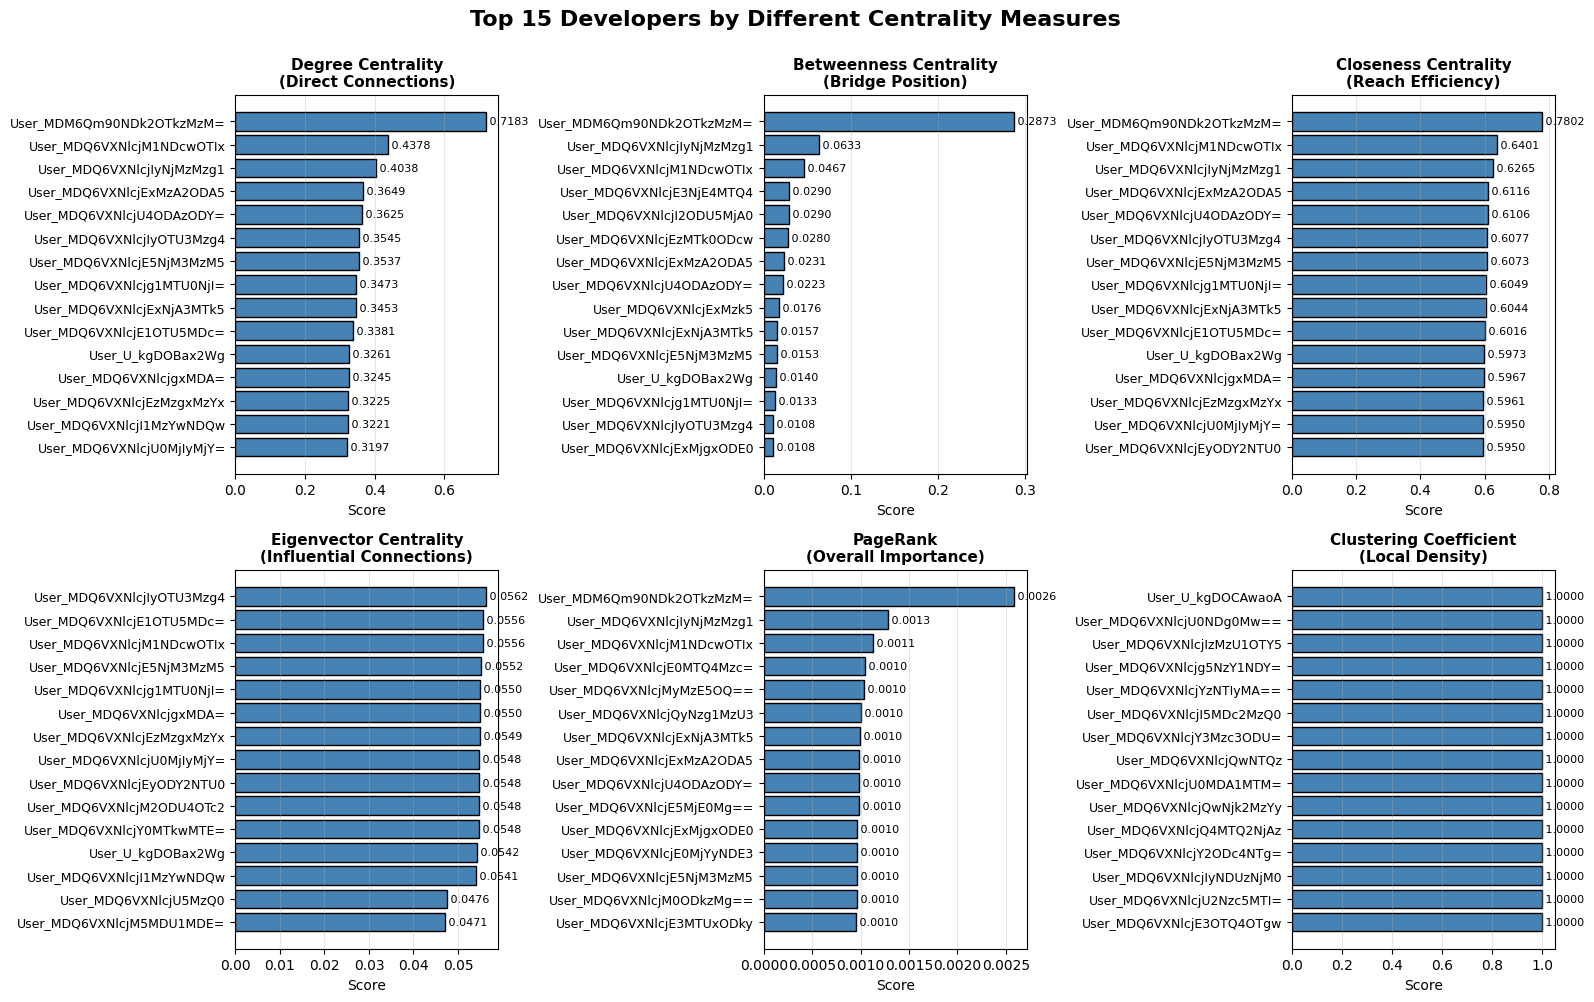

In [57]:
print("\n" + "="*70)
print("CENTRALITY MEASURES ANALYSIS")
print("="*70)

# Biểu đồ : So sánh nhiều Centrality Measures
def compare_centrality_measures(metrics_df, top_n=15, figsize=(16, 10)):
    """
    So sánh các chỉ số centrality khác nhau
    """
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    
    centrality_cols = [
        'degree_centrality',
        'betweenness_centrality',
        'closeness_centrality',
        'eigenvector_centrality',
        'pagerank',
        'clustering_coefficient'
    ]
    
    titles = [
        'Degree Centrality\n(Direct Connections)',
        'Betweenness Centrality\n(Bridge Position)',
        'Closeness Centrality\n(Reach Efficiency)',
        'Eigenvector Centrality\n(Influential Connections)',
        'PageRank\n(Overall Importance)',
        'Clustering Coefficient\n(Local Density)'
    ]
    
    for ax, col, title in zip(axes.flatten(), centrality_cols, titles):
        top_data = metrics_df.nlargest(top_n, col)
        
        ax.barh(range(top_n), top_data[col].values, color='steelblue', edgecolor='black')
        ax.set_yticks(range(top_n))
        ax.set_yticklabels(top_data['name'].values, fontsize=9)
        ax.invert_yaxis()
        ax.set_xlabel('Score', fontsize=10)
        ax.set_title(title, fontsize=11, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        
        for i, v in enumerate(top_data[col].values):
            ax.text(v, i, f' {v:.4f}', va='center', fontsize=8)
    
    plt.suptitle(f'Top {top_n} Developers by Different Centrality Measures', 
                 fontsize=16, fontweight='bold', y=0.998)
    plt.tight_layout()
    plt.savefig('centrality_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

compare_centrality_measures(metrics_df, top_n=15)

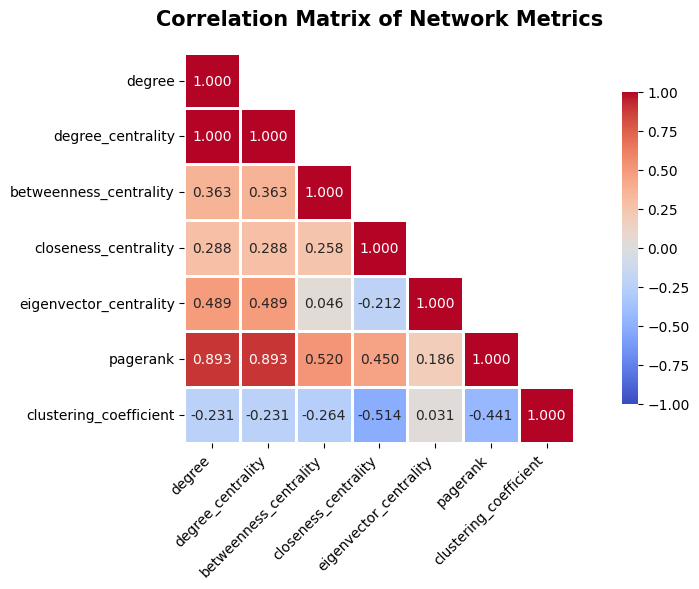

In [58]:
# Biểu đồ : Correlation Heatmap
def plot_metrics_correlation(metrics_df, figsize=(10, 6)):
    """
    Vẽ heatmap tương quan giữa các metrics
    """
    numeric_cols = [
        'degree', 'degree_centrality', 'betweenness_centrality',
        'closeness_centrality', 'eigenvector_centrality',
        'pagerank', 'clustering_coefficient'
    ]
    
    corr_matrix = metrics_df[numeric_cols].corr()
    
    plt.figure(figsize=figsize)
    
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    
    sns.heatmap(corr_matrix, 
                mask=mask,
                annot=True, 
                fmt='.3f',
                cmap='coolwarm',
                center=0,
                square=True,
                linewidths=1,
                cbar_kws={"shrink": 0.8},
                vmin=-1, vmax=1)
    
    plt.title('Correlation Matrix of Network Metrics', 
              fontsize=15, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('metrics_correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_metrics_correlation(metrics_df)

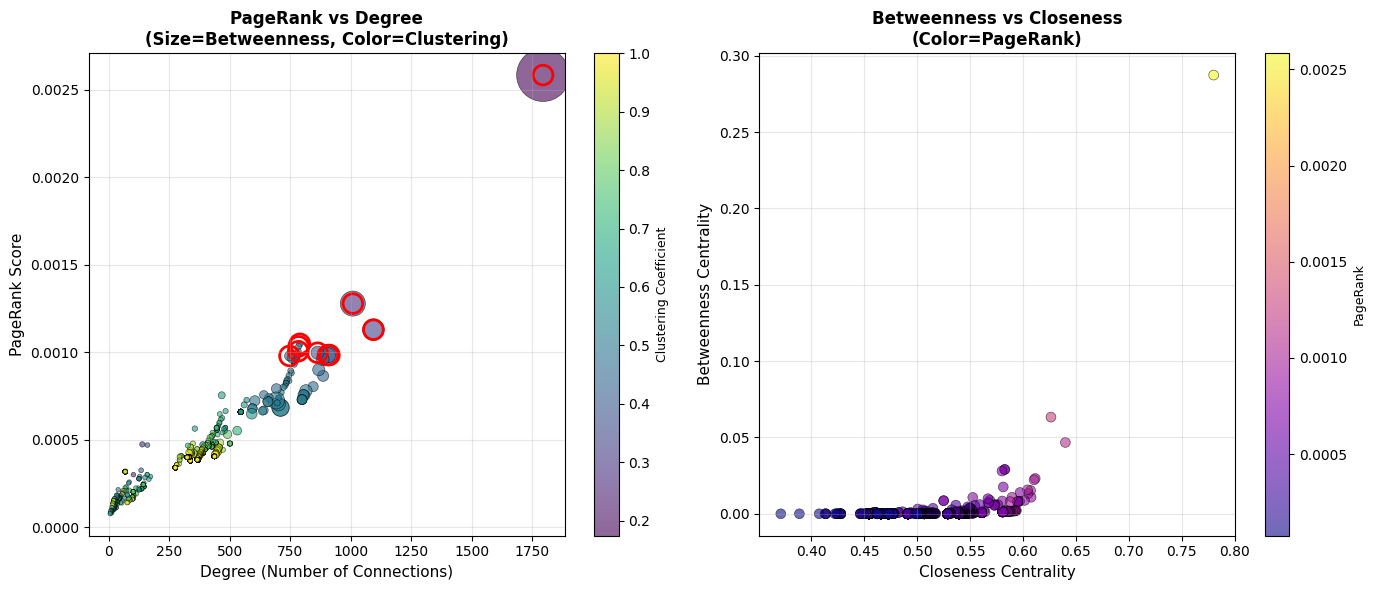

In [ ]:
# Biểu đồ : Scatter Plots
def plot_pagerank_vs_degree(metrics_df, figsize=(14, 6)):
    """
    Scatter plots: PageRank vs Degree và các phân tích khác
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: PageRank vs Degree
    ax1 = axes[0]
    scatter = ax1.scatter(metrics_df['degree'], 
                         metrics_df['pagerank'],
                         c=metrics_df['clustering_coefficient'],
                         s=metrics_df['betweenness_centrality'] * 5000 + 10,
                         alpha=0.6,
                         cmap='viridis',
                         edgecolors='black',
                         linewidth=0.5)
    
    ax1.set_xlabel('Degree (Number of Connections)', fontsize=11)
    ax1.set_ylabel('PageRank Score', fontsize=11)
    ax1.set_title('PageRank vs Degree\n(Size=Betweenness, Color=Clustering)', 
                  fontsize=12, fontweight='bold')
    ax1.grid(alpha=0.3)
    
    cbar1 = plt.colorbar(scatter, ax=ax1)
    cbar1.set_label('Clustering Coefficient', fontsize=9)
    
    top_10 = metrics_df.nlargest(10, 'pagerank')
    ax1.scatter(top_10['degree'], top_10['pagerank'], 
               s=200, facecolors='none', edgecolors='red', linewidth=2)
    
    # Plot 2: Betweenness vs Closeness
    ax2 = axes[1]
    scatter2 = ax2.scatter(metrics_df['closeness_centrality'],
                          metrics_df['betweenness_centrality'],
                          c=metrics_df['pagerank'],
                          s=50,
                          alpha=0.6,
                          cmap='plasma',
                          edgecolors='black',
                          linewidth=0.5)
    
    ax2.set_xlabel('Closeness Centrality', fontsize=11)
    ax2.set_ylabel('Betweenness Centrality', fontsize=11)
    ax2.set_title('Betweenness vs Closeness\n(Color=PageRank)', 
                  fontsize=12, fontweight='bold')
    ax2.grid(alpha=0.3)
    
    cbar2 = plt.colorbar(scatter2, ax=ax2)
    cbar2.set_label('PageRank', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('centrality_scatter_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_pagerank_vs_degree(metrics_df)


🌍 COMMUNITY CHARACTERISTICS ANALYSIS


C:\Users\84941\AppData\Local\Temp\ipykernel_19412\3183452702.py:45: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from current font.
  plt.tight_layout()
C:\Users\84941\AppData\Local\Temp\ipykernel_19412\3183452702.py:45: UserWarning: Glyph 28023 (\N{CJK UNIFIED IDEOGRAPH-6D77}) missing from current font.
  plt.tight_layout()
C:\Users\84941\AppData\Local\Temp\ipykernel_19412\3183452702.py:46: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from current font.
  plt.savefig('community_demographics_location.png', dpi=300, bbox_inches='tight')
C:\Users\84941\AppData\Local\Temp\ipykernel_19412\3183452702.py:46: UserWarning: Glyph 28023 (\N{CJK UNIFIED IDEOGRAPH-6D77}) missing from current font.
  plt.savefig('community_demographics_location.png', dpi=300, bbox_inches='tight')
c:\Users\84941\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from curr

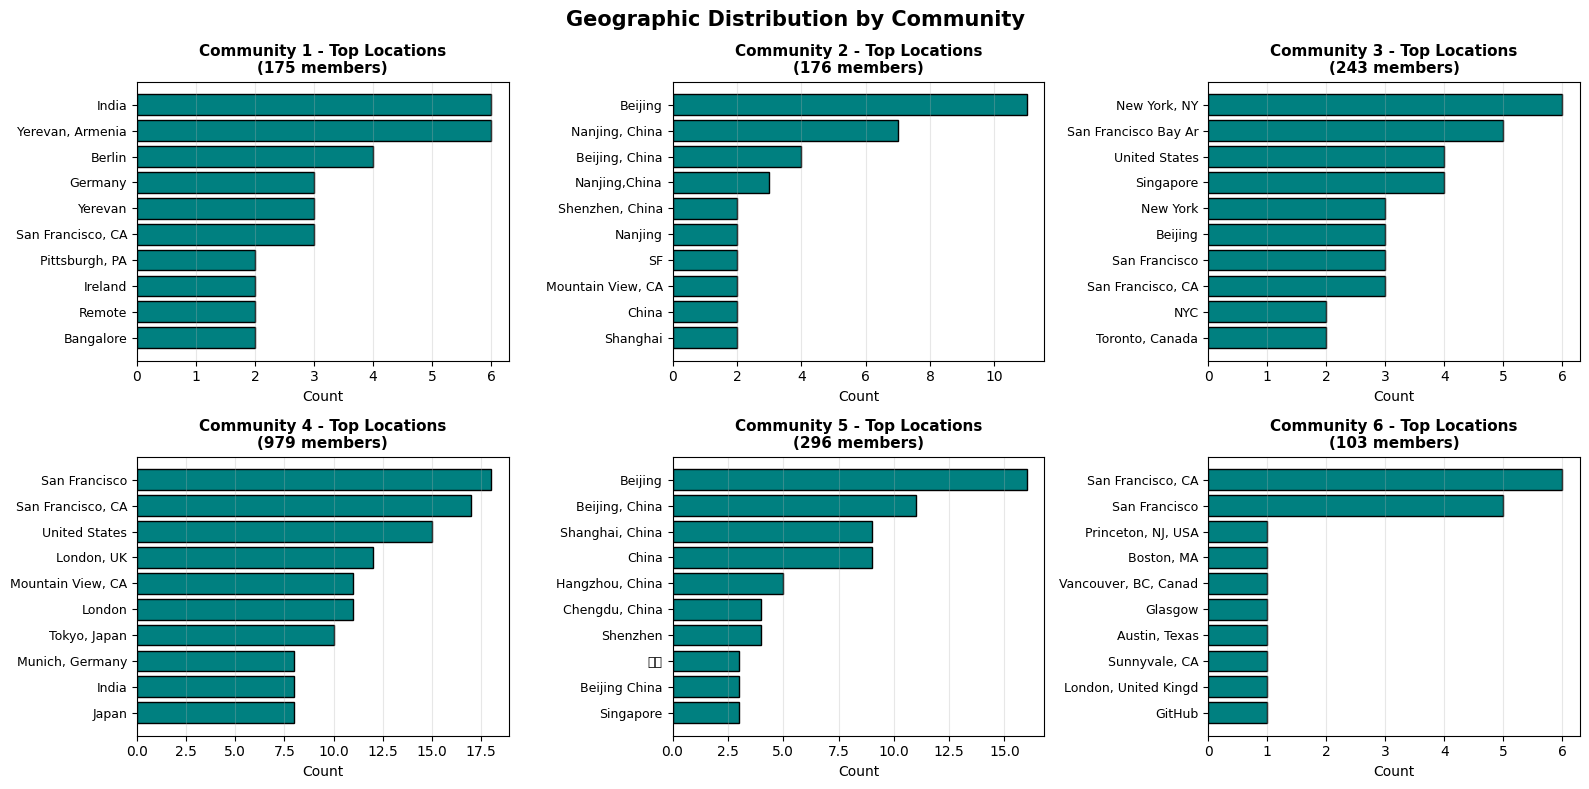

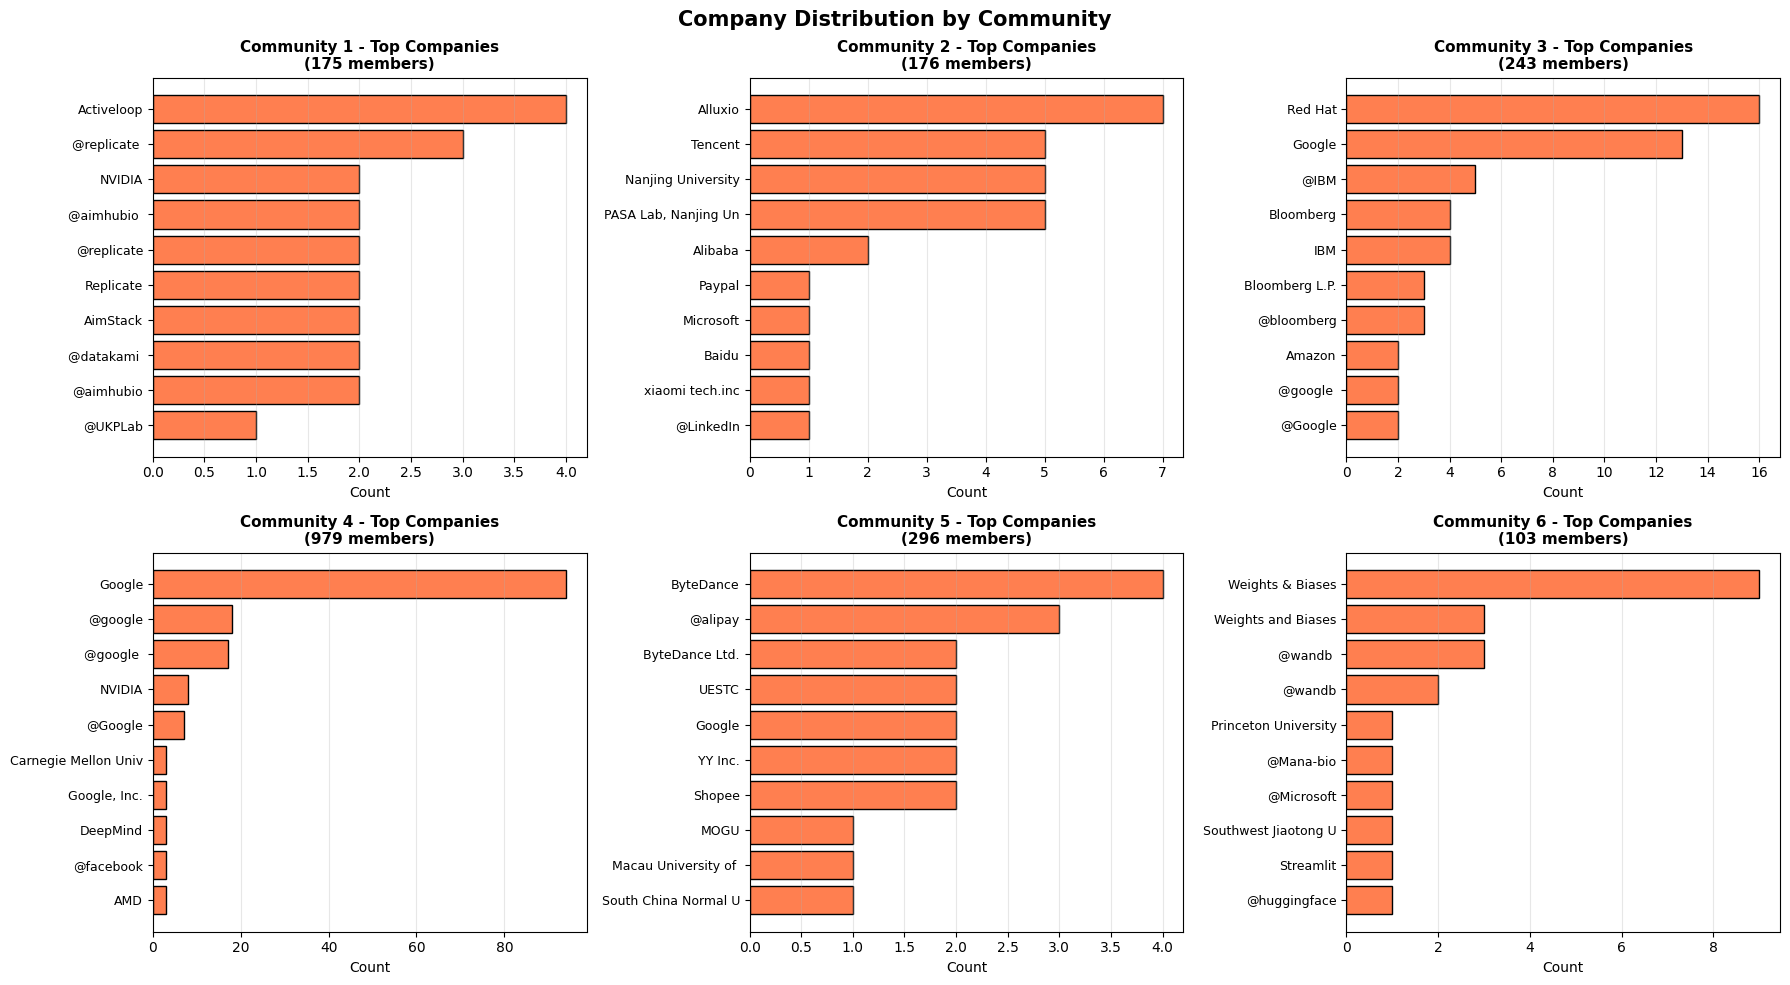

In [60]:
print("\n" + "="*70)
print("🌍 COMMUNITY CHARACTERISTICS ANALYSIS")
print("="*70)

# Biểu đồ : Location & Company Distribution by Community
def analyze_community_demographics(G, community_results, users_df, top_n_comm=6):
    """
    Phân tích đặc điểm địa lý và công ty của các communities
    """
    best_method = max(community_results.items(), key=lambda x: x[1].get('modularity', 0))
    method_name, result = best_method
    communities = result['communities']
    communities_sorted = sorted(communities, key=len, reverse=True)
    
    # Tạo mapping
    comm_map = {node: i for i, comm in enumerate(communities) for node in comm}
    users_df_temp = users_df.copy()
    users_df_temp['community'] = users_df_temp['user_id'].map(comm_map)
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 8))
    
    for i in range(min(top_n_comm, 6)):
        ax = axes.flatten()[i]
        
        comm_id = i
        comm_users = users_df_temp[users_df_temp['community'] == comm_id]
        
        # Top locations
        top_locs = comm_users['location'].value_counts().head(10)
        
        if not top_locs.empty:
            ax.barh(range(len(top_locs)), top_locs.values, color='teal', edgecolor='black')
            ax.set_yticks(range(len(top_locs)))
            ax.set_yticklabels([str(loc)[:20] for loc in top_locs.index], fontsize=9)
            ax.invert_yaxis()
            ax.set_xlabel('Count', fontsize=10)
            ax.set_title(f'Community {i+1} - Top Locations\n({len(comm_users)} members)', 
                        fontsize=11, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'No location data', ha='center', va='center')
            ax.axis('off')
    
    plt.suptitle('Geographic Distribution by Community', fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.savefig('community_demographics_location.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Similar for companies
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    for i in range(min(top_n_comm, 6)):
        ax = axes.flatten()[i]
        
        comm_id = i
        comm_users = users_df_temp[users_df_temp['community'] == comm_id]
        
        top_comps = comm_users['company'].value_counts().head(10)
        
        if not top_comps.empty:
            ax.barh(range(len(top_comps)), top_comps.values, color='coral', edgecolor='black')
            ax.set_yticks(range(len(top_comps)))
            ax.set_yticklabels([str(c)[:20] for c in top_comps.index], fontsize=9)
            ax.invert_yaxis()
            ax.set_xlabel('Count', fontsize=10)
            ax.set_title(f'Community {i+1} - Top Companies\n({len(comm_users)} members)', 
                        fontsize=11, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'No company data', ha='center', va='center')
            ax.axis('off')
    
    plt.suptitle('Company Distribution by Community', fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.savefig('community_demographics_company.png', dpi=300, bbox_inches='tight')
    plt.show()

analyze_community_demographics(G_2500, community_results, users, top_n_comm=6)

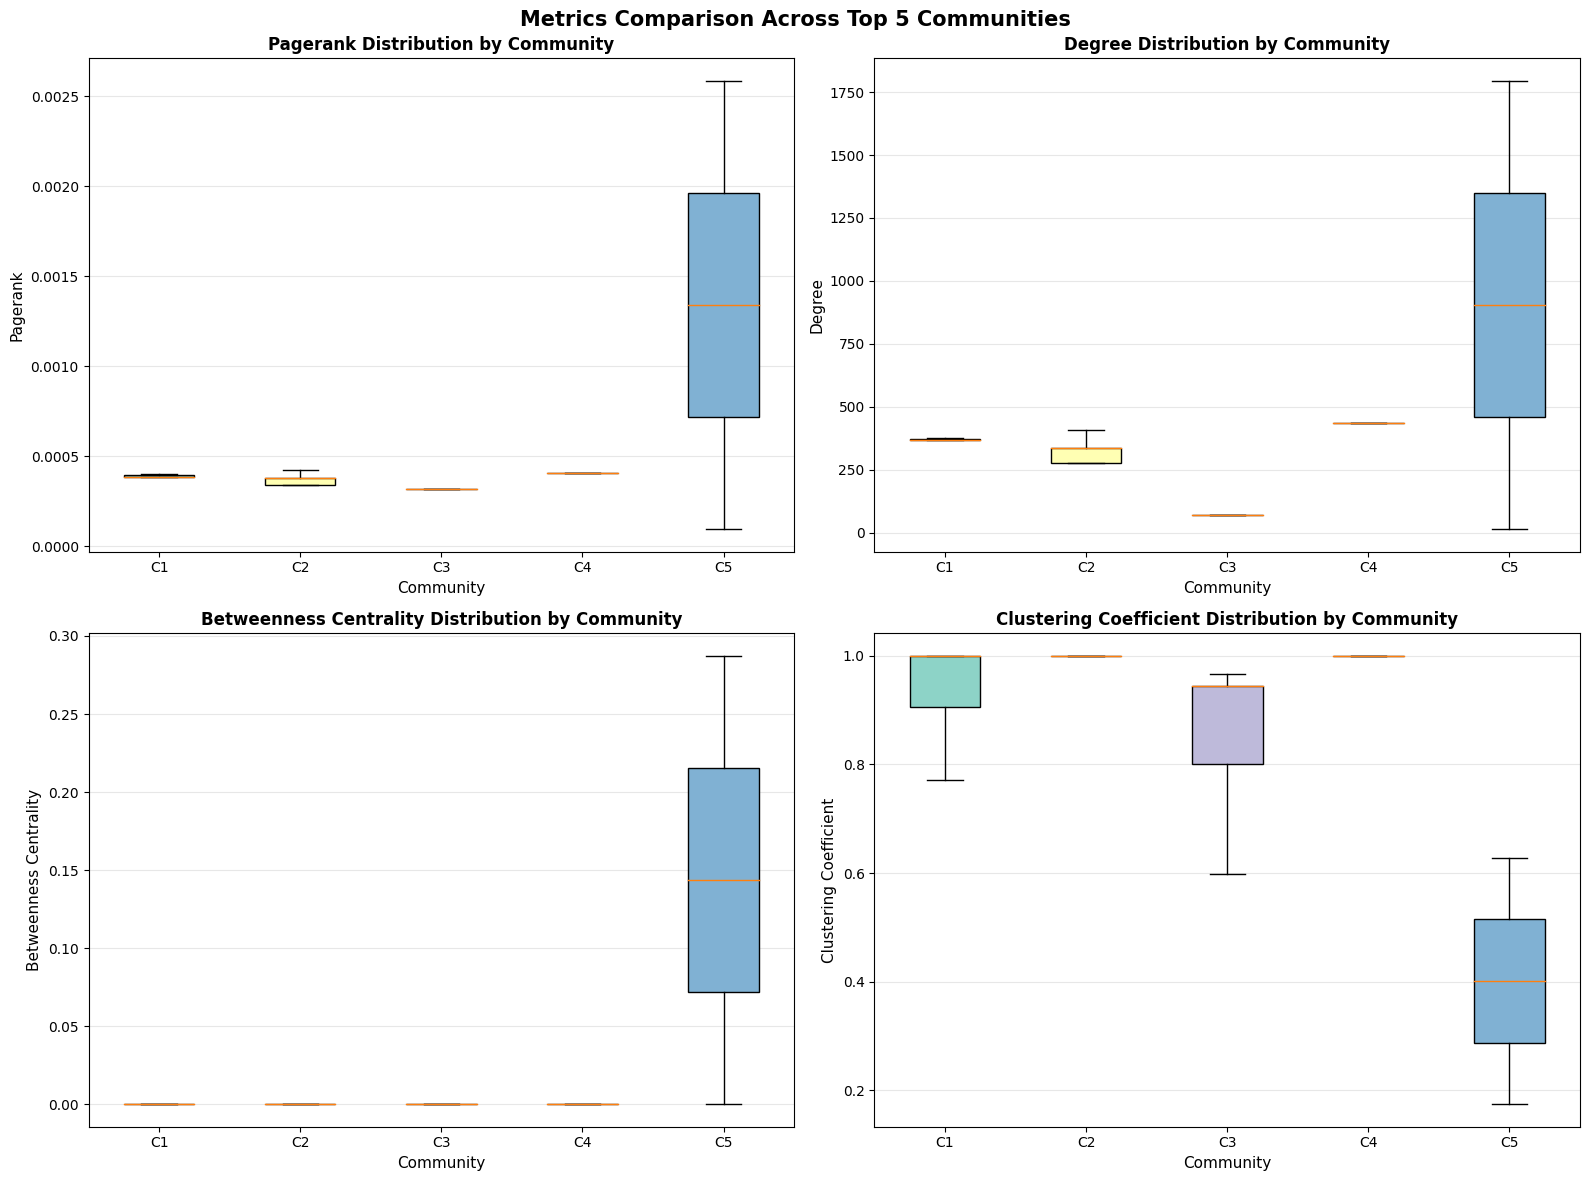

In [63]:
# Biểu đồ : Community Metrics Boxplot
def compare_metrics_across_communities(G, community_results, metrics_df, top_n=5):
    """
    So sánh các metrics giữa các communities
    """
    best_method = max(community_results.items(), key=lambda x: x[1].get('modularity', 0))
    method_name, result = best_method
    communities = result['communities']
    communities_sorted = sorted(communities, key=len, reverse=True)[:top_n]
    
    # Map nodes to communities
    comm_map = {}
    for i, comm in enumerate(communities_sorted):
        for node in comm:
            comm_map[node] = f'C{i+1}'
    
    metrics_df_temp = metrics_df.copy()
    metrics_df_temp['community'] = metrics_df_temp['user_id'].map(comm_map)
    metrics_df_temp = metrics_df_temp.dropna(subset=['community'])
    
    # Metrics to compare
    metrics_to_plot = ['pagerank', 'degree', 'betweenness_centrality', 'clustering_coefficient']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    for ax, metric in zip(axes.flatten(), metrics_to_plot):
        data_to_plot = [metrics_df_temp[metrics_df_temp['community'] == f'C{i+1}'][metric].values 
                        for i in range(top_n)]
        
        bp = ax.boxplot(data_to_plot, labels=[f'C{i+1}' for i in range(top_n)], 
                       patch_artist=True, showfliers=False)
        
        # Color boxes
        colors = plt.cm.Set3(range(top_n))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        
        ax.set_xlabel('Community', fontsize=11)
        ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=11)
        ax.set_title(f'{metric.replace("_", " ").title()} Distribution by Community', 
                    fontsize=12, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
    
    plt.suptitle(f'Metrics Comparison Across Top {top_n} Communities', 
                 fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.savefig('community_metrics_boxplot.png', dpi=300, bbox_inches='tight')
    plt.show()

compare_metrics_across_communities(G_2500, community_results, metrics_df, top_n=5)


VISUALIZING NETWORK
Nodes: 2500 | Edges: 442836
Layout: spring
Using spring layout...
Large graph detected — sampling 1000 nodes for visualization.


C:\Users\84941\AppData\Local\Temp\ipykernel_14796\2914052173.py:70: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, label='PageRank Score', orientation='vertical', fraction=0.03, pad=0.02)


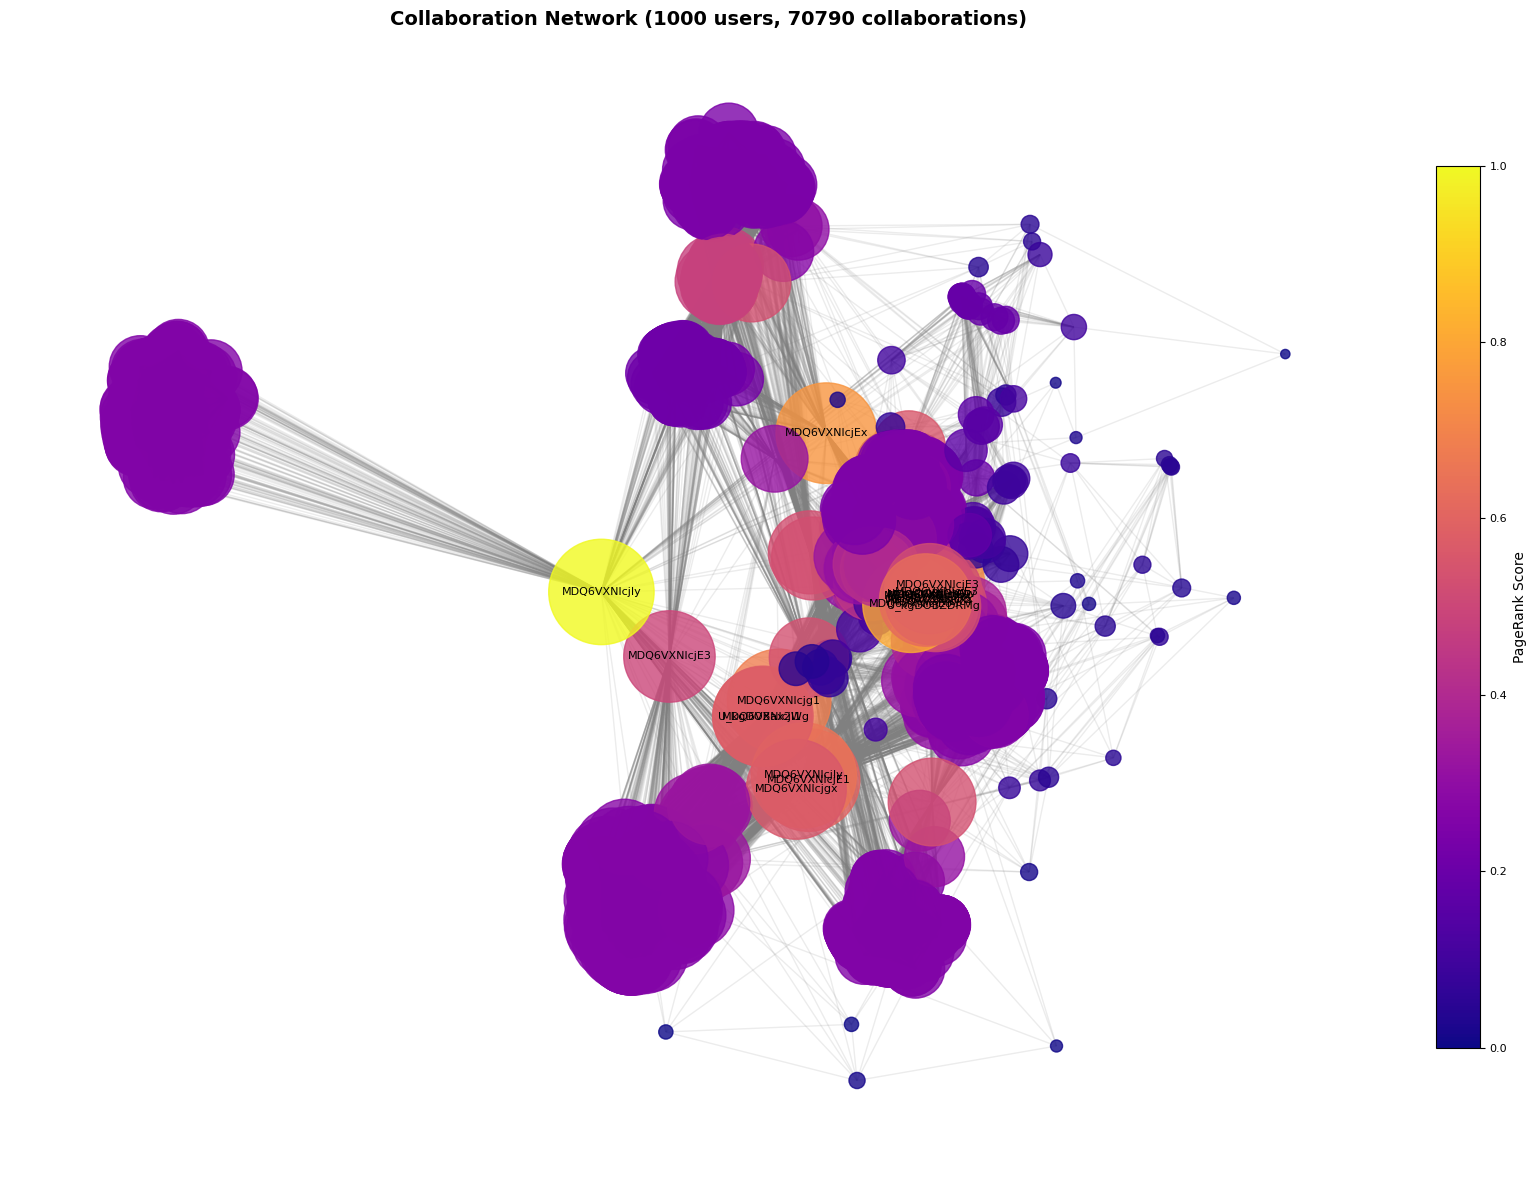

Visualization complete.



In [ ]:
# Vẽ trực quan mạng lưới cơ bản, tối ưu cho đồ thị lớn (hiển thị 1000 node)
def visualize_network_basic(G, metrics_df, layout='spring', figsize=(15, 12)):
    """Vẽ trực quan mạng lưới cơ bản, tối ưu cho đồ thị lớn (hiển thị 1000 node)"""

    print("\n" + "="*60)
    print("VISUALIZING NETWORK")
    print("="*60)
    print(f"Nodes: {G.number_of_nodes()} | Edges: {G.number_of_edges()}")
    print(f"Layout: {layout}")

    plt.figure(figsize=figsize)

    # Chọn layout
    if layout == 'spring':
        print("Using spring layout...")
        pos = nx.spring_layout(G, k=1/np.sqrt(G.number_of_nodes()), iterations=50)
    elif layout == 'kamada_kawai':
        print("Using Kamada-Kawai layout...")
        pos = nx.kamada_kawai_layout(G)
    elif layout == 'circular':
        print("Using circular layout...")
        pos = nx.circular_layout(G)
    else:
        print("Using random layout...")
        pos = nx.random_layout(G)

    # Giới hạn số node hiển thị để tránh lag
    if G.number_of_nodes() > 1000:
        print("Large graph detected — sampling 1000 nodes for visualization.")
        sampled_nodes = list(np.random.choice(list(G.nodes()), 1000, replace=False))
        H = G.subgraph(sampled_nodes)
        metrics_df_sub = metrics_df[metrics_df['user_id'].isin(sampled_nodes)]
    else:
        H = G
        metrics_df_sub = metrics_df

    # Kích thước node dựa trên degree
    node_sizes = [H.degree(node) * 15 for node in H.nodes()]

    # Màu node dựa trên PageRank
    pagerank_dict = dict(zip(metrics_df_sub['user_id'], metrics_df_sub['pagerank']))
    pagerank_values = [pagerank_dict.get(node, 0) * 10000 for node in H.nodes()]

    # Vẽ mạng
    nx.draw_networkx_nodes(
        H, pos,
        node_size=node_sizes,
        node_color=pagerank_values,
        cmap='plasma',      
        alpha=0.8
    )

    nx.draw_networkx_edges(H, pos, alpha=0.15, edge_color='gray')

    # Nhãn cho các node nổi bật nhất
    top_nodes = metrics_df_sub.head(20)['user_id'].values
    labels = {node: H.nodes[node].get('name', str(node))[:12]
              for node in top_nodes if node in H.nodes()}
    nx.draw_networkx_labels(H, pos, labels, font_size=8)

    plt.title(
        f"Collaboration Network ({H.number_of_nodes()} users, {H.number_of_edges()} collaborations)",
        fontsize=14, fontweight='bold'
    )
    plt.axis('off')
    plt.tight_layout()

    # Thanh màu (colorbar)
    sm = plt.cm.ScalarMappable(cmap='plasma')
    sm.set_array([])
    cbar = plt.colorbar(sm, label='PageRank Score', orientation='vertical', fraction=0.03, pad=0.02)
    cbar.ax.tick_params(labelsize=8)

    plt.show()
    print("Visualization complete.\n")

visualize_network_basic(G_2500, metrics_df, layout='spring')
